# <a id='toc1_'></a>[UCRB Streamflow Sandbox](#toc0_)
Author: Daniel Hogan
Creation Date: 2023-04-25

This notebook explores the general trends in streamflow, precipitation, and temperature across the UCRB.
Figure 1 from the publication is created within, along with figures in the SI Appendix. See table of contents to get main ideas.

**Note: Links in the TOC will not work in GitHub**

**Table of contents**<a id='toc0_'></a>    
- [UCRB Streamflow Sandbox](#toc1_)    
    - [Import Packages](#toc1_1_1_)    
- [Import UCRB PRISM temperature and precipitation data](#toc2_)    
- [Import naturalized streamflow](#toc3_)    
- [Plot Precipitation, Streamflow and Temperature all together](#toc4_)    
- [Let's change to focusing on our HCDN basins](#toc5_)    
    - [Trying k-means clustering to identify clusters by elevation group](#toc5_1_1_)    
- [Plot winter and spring precipitation against naturalized streamflow](#toc6_)    
- [Working on mimicing the plots from Biederman et al.](#toc7_)    
    - [Low Elevation Sites](#toc7_1_1_)    
    - [Mid Elevation Sites](#toc7_1_2_)    
    - [High Elevation Sites](#toc7_1_3_)    
    - [Run an ANOVA test looking at changes between elevation groups](#toc7_1_4_)    
    - [Quick Statistical test for a single site](#toc7_1_5_)    
    - [Double Mass Plots](#toc7_1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Import Packages](#toc0_)

In [1]:
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt
# following code blocks adapted from lab 3-1
import statsmodels.api as sm
from statsmodels.formula.api import ols
# For K-mean clustering
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


# <a id='toc2_'></a>[Import UCRB PRISM temperature and precipitation data](#toc0_)

In [2]:
# import UCRB precipitation
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [3]:
if not os.path.exists('../data/etdata/prism_tmean_normals'):
    # pull in PRISM data
    outpath = '../data/etdata/PRISM_tmean_30yr_normal_800mM4_annual_bil/'
    prism_tmean_normal = rxr.open_rasterio(outpath + 'PRISM_tmean_30yr_normal_800mM4_annual_bil.bil', masked=True)
    ucrb_prism_tmean_normal = prism_tmean_normal.rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry).squeeze()
    # save to file
    ucrb_prism_tmean_normal.to_netcdf('../data/etdata/prism_tmean_normals.nc')
else:
    ucrb_prism_tmean_normal = xr.open_dataset('../data/etdata/prism_tmean_normals.nc')

In [4]:
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '../data/precipdata/PRISM/PRISM_ppt_stable_4km/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_ds = prism_4km_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ds = prism_4km_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_ds = prism_4km_ds.sortby('month')
       prism_4km_ds = prism_4km_ds.sel(month=slice('1981-01-01', '2022-09-01'))

In [5]:
# Download historic PRISM precipitation from 4km product 
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       outpath = '/storage/dlhogan/sos/data/PRISM_ppt/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_historic_ds = xr.concat(prism_list, dim='band')
       prism_4km_historic_ds = prism_4km_historic_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_historic_ds = prism_4km_historic_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_historic_ds = prism_4km_historic_ds.sortby('month')
       prism_4km_all_ds = xr.concat([prism_4km_historic_ds, prism_4km_ds], dim='month', join='override')
       prism_4km_all_ds.to_netcdf('../data/precipdata/prism_4km_ucrb.nc')
else:
       prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
       prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})

In [6]:
if not os.path.exists('../data/etdata/prism_tmean_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '/storage/dlhogan/sos/data/PRISM/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 39)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_tmean_ds = xr.concat(prism_list, dim='band')
       prism_4km_tmean_ds = prism_4km_tmean_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean_ds = prism_4km_tmean_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_tmean_ds = prism_4km_tmean_ds.sortby('month')
       prism_4km_tmean_ds = prism_4km_tmean_ds.sel(month=slice('1895-01-01', '2022-09-01'))

       prism_4km_tmean_ds.to_netcdf('../data/etdata/prism_tmean_4km_ucrb.nc')
else:
       prism_4km_tmean_ds = xr.open_dataset('../data/etdata/prism_tmean_4km_ucrb.nc')

# <a id='toc3_'></a>[Import naturalized streamflow](#toc0_)

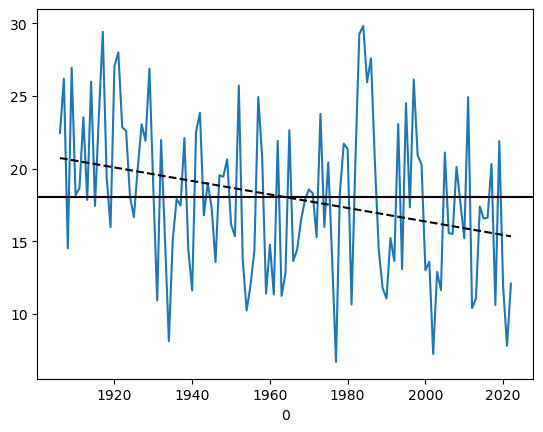

In [7]:
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()
slope1, intercept1, _,_,_ = stats.linregress(ucrb_naturalized_streamflow.index,ucrb_naturalized_streamflow['annual_flow_km3'].values)
ucrb_naturalized_streamflow['annual_flow_km3'].plot()
plt.plot(ucrb_naturalized_streamflow.index , slope1*ucrb_naturalized_streamflow.index + intercept1, ls='--',color='k')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='k')

In [8]:
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

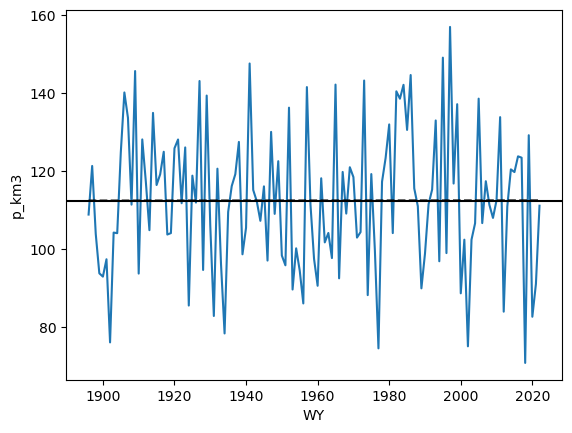

In [9]:
slope2, intercept2, _,_,_ = stats.linregress(annual_p_km3.WY,annual_p_km3['p_km3'].values)
annual_p_km3['p_km3'].plot()
plt.plot(annual_p_km3.WY , slope2*annual_p_km3.WY + intercept2, ls='--',color='k')
plt.axhline(annual_p_km3['p_km3'].mean(), color='k')

In [10]:
t_mean = prism_4km_tmean_ds.where(prism_4km_tmean_ds>-100).mean(dim=['x','y'])
t_mean['WY'] = t_mean.month.dt.year.where(t_mean.month.dt.month<10, t_mean.month.dt.year+1)
annual_t_mean = t_mean.groupby('WY').mean()
annual_t_mean = annual_t_mean.rename({'__xarray_dataarray_variable__':'t_mean'})
annual_t_mean = annual_t_mean.sel(WY=slice(1896,2022))


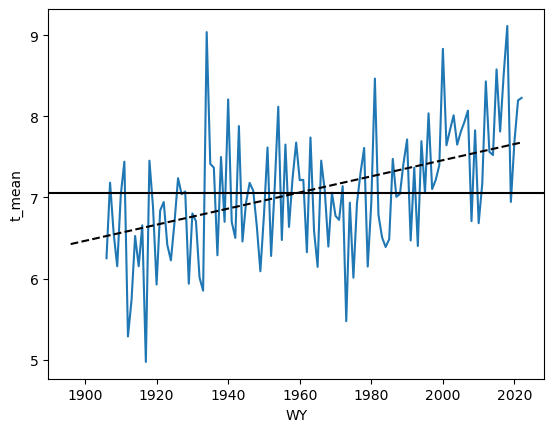

In [11]:
slope3, intercept3, _,_,_ = stats.linregress(annual_t_mean.WY,annual_t_mean['t_mean'].values)
annual_t_mean['t_mean'].sel(WY=slice(1906,2022)).plot()
plt.plot(annual_t_mean.WY , slope3*annual_t_mean.WY + intercept3, ls='--',color='k')
plt.axhline(annual_t_mean['t_mean'].mean(), color='k')

# <a id='toc4_'></a>[Plot Precipitation, Streamflow and Temperature all together](#toc0_)

In [12]:
# convert ucrb index to datetime and add month=1 and day=1
ucrb_naturalized_streamflow.index = pd.to_datetime([dt.datetime(x,1,1) for x in ucrb_naturalized_streamflow.index])

In [14]:
# Create a copy to be used in plotting the x-axis
ucrb_naturalized_streamflow_tmp = ucrb_naturalized_streamflow.copy()
ucrb_naturalized_streamflow_tmp.index = ucrb_naturalized_streamflow.index.year

In [15]:
# Function used for adding intervals to the plot
import matplotlib as mpl
def add_interval(ax, xdata, ydata, color, caps="  "):
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, color=color, linewidth=3))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 24,
        'color': line.get_color(),
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1]), **anno_args)
    return (line,(a0,a1))

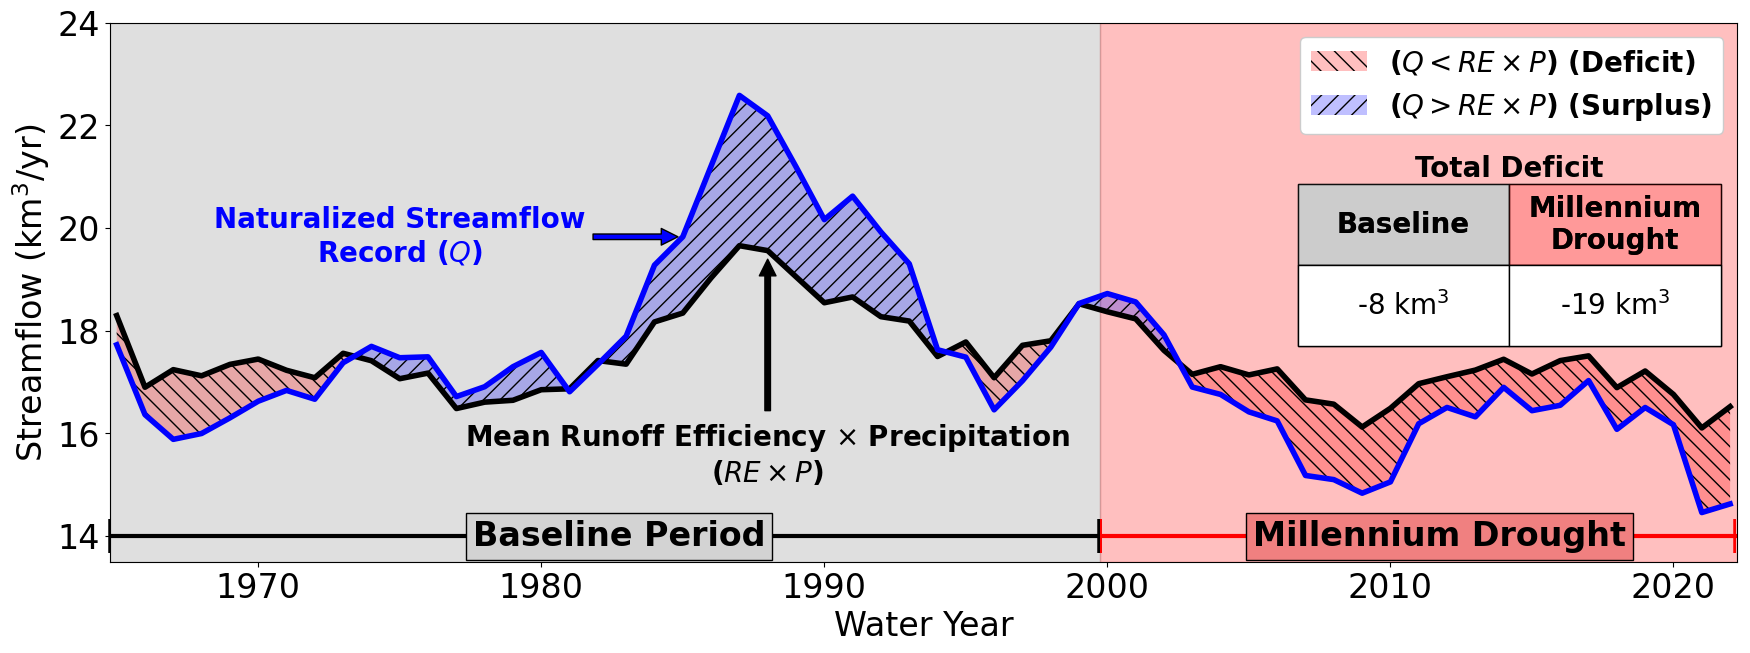

In [142]:
fig, ax = plt.subplots(figsize=(21,7))
runoff_ratio = 0.1525*(annual_p_km3['p_km3'].sel(WY=slice(1964,2022)))
# plot line of P*runoff ratio
plt.plot(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
         runoff_ratio.rolling({'WY':10},min_periods=2).mean() , 
         color='k', 
         lw=4, 
         )
# plot naturalized streamflow
plt.plot(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
         ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
         color='blue', 
         lw=4, 
         )

# hatch between two plots
plt.fill_between(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
                 runoff_ratio.rolling({'WY':10},min_periods=2).mean(),
                 ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 where=runoff_ratio.rolling({'WY':10},min_periods=2).mean()>=ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 facecolor='red', 
                 hatch='\\\\',
                 alpha=0.25, 
                 interpolate=True,
                 label=r'($Q < RE \times P$) (Deficit)')
plt.fill_between(ucrb_naturalized_streamflow.loc[dt.date(1964,1,1):dt.date(2022,1,1)].index,
                 runoff_ratio.rolling({'WY':10},min_periods=2).mean() ,
                 ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 where=runoff_ratio.rolling({'WY':10},min_periods=2).mean()<ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean(), 
                 facecolor='blue',
                 hatch='//', 
                 alpha=0.25, 
                 interpolate=True,
                 label=r'($Q > RE \times P$) (Surplus)')

# plt.ylim(runoff_ratio.rolling(10).mean().mean()-0.05,runoff_ratio.rolling(10).mean().mean()+0.05)
plt.axvspan(dt.date(1999,10,1),dt.date(2022,10,1),color='red',alpha=0.25,zorder=0)
# add a text box to label this span as the "Baseline Period"
plt.text(dt.date(2011,10,1), 14, 
        'Millennium Drought', 
        fontsize=24, 
        color='black', 
        ha='center', va='center', 
        fontweight='bold', 
        bbox={'facecolor':'lightcoral', 'pad':5})
# draw a horizontal line between the start and end of the baseline period
add_interval(ax,(dt.date(1999,10,1),dt.date(2022,3,1)),(14,14),'red', caps='||')
# add a text box to label this span as the "Baseline Period"
plt.text(dt.date(1982,10,1), 14, 
         'Baseline Period',
          fontsize=24, 
          color='black',
          backgroundcolor='lightgray', 
          ha='center', va='center',
          fontweight='bold', 
          bbox={'facecolor':'lightgray', 'pad':5})
# draw a horizontal line between the start and end of the baseline period
add_interval(ax,(dt.date(1964,10,1),dt.date(1999,9,1)),(14,14),'black', caps='||')
plt.axvspan(dt.date(1964,10,1),dt.date(1999,10,1),color='grey',alpha=0.25, zorder=0)

# add a horizontal line at the minimum of streaflow during the baseline period
diff_baseline = (runoff_ratio.rolling({'WY':10},min_periods=2).mean() - ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean()).sel(WY=slice(1964,1999))
total_diff_baseline = diff_baseline.where(diff_baseline>0).sum()
total_surplus_baseline= diff_baseline.where(diff_baseline<0).sum()
        
# add a horizontal line at the minimum of streamflow during the Millennium Drought
diff_md = (runoff_ratio.rolling({'WY':10},min_periods=2).mean() - ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean()).sel(WY=slice(2000,2022))   
total_diff_md = diff_md.where(diff_md>0).sum()
total_surplus_md= diff_md.where(diff_md<0).sum()

######## Table Formatting ########
col_labels=['Baseline','Millennium\nDrought']
row_labels=['Total Deficit']#,'Total Surplus']
table_vals=[[
            '{:.0f} km$^3$'.format(-total_diff_baseline),
            '{:.0f} km$^3$'.format(-total_diff_md)],
            ]#[
        #     '{:.0f} km$^3$'.format(-total_surplus_baseline),
        #     '{:.0f} km$^3$'.format(-total_surplus_md)
        #     ]]
# hidden table to help with transparency
hidden_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*2,
                #   rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.73, 0.4, 0.26, 0.3],
                  cellLoc='center',
                  rowLoc='center')

# bold the column and row labels
for (row, col), cell in hidden_table.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
hidden_table.auto_set_font_size(False)
hidden_table.set_fontsize(20)
hidden_table.scale(1.5, 4.2)
# table with data
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*2,
                #   rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.73, 0.4, 0.26, 0.3],
                  cellLoc='center',
                  rowLoc='center',
                  colColours=['grey','red'])
# bold the column and row labels
for (row, col), cell in the_table.get_celld().items():
  if (row == 0) or (col == -1):
    cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    cell.set_alpha(0.4)
the_table.auto_set_font_size(False)
the_table.set_fontsize(20)
the_table.scale(1.5, 4.2)
# add title as text above table
plt.text((0.73+.99)/2, 0.73, 'Total Deficit',
        fontsize=20, color='black',
        fontweight='bold',
        ha='center', va='center',
        transform=ax.transAxes)

# add an arrow and point to mean runoff efficiency line
plt.annotate(r'Mean Runoff Efficiency $\times$ Precipitation'+'\n'+r'($RE \times P$)',
                xy=(dt.date(1988,1,1),runoff_ratio.rolling({'WY':10},min_periods=2).mean().sel(WY=1988).values),
                xytext=(dt.date(1988,1,1),runoff_ratio.rolling({'WY':10},min_periods=2).mean().sel(WY=1988).values-4.5),
                # center text
                ha='center',
                # increase text size
                size=20,
                # bold text
                weight='bold',
                # set arrow properties
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
# add an arrow and point to mean runoff efficiency line
plt.annotate('Naturalized Streamflow\nRecord '+r'($Q$)',
                xy=(dt.date(1985,1,1),ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean().loc[1985]),
                xytext=(dt.date(1975,1,1),ucrb_naturalized_streamflow_tmp['annual_flow_km3'].loc[1964:2022].rolling(10,min_periods=2,).mean().loc[1985]),
                # center text
                ha='center',
                va='center',
                # increase text size
                size=20,
                # bold text
                weight='bold',
                color='blue',
                # set arrow properties
                arrowprops=dict(facecolor='blue', shrink=0.05),
                )
                  
plt.xlim(dt.date(1964,10,1),dt.date(2022,4,1))
#increase y-axis tick label size
plt.yticks(size=24);
plt.xticks(size=24);
plt.legend(loc='upper right',
           framealpha=1, 
           ncols=1, 
           prop={'weight':'bold',
                 'size':20})
plt.ylim(13.5,24)
plt.ylabel('Streamflow (km$^3$/yr)', color='black', size=24)
plt.xlabel('Water Year', color='black', size=24)
# add title saying "15-year Rolling Mean UCRB Runoff Ratio"
# plt.title('UCRB Naturalized Streamflow and Runoff Efficiency * Precipitation\n10-year Rolling Mean', size=16)
# save figure at 700 dpi and 9x6 centimeters
fig.savefig('../figures/precip_deficit_streamflow_deficit.png', dpi=700, pad_inches=0.1)

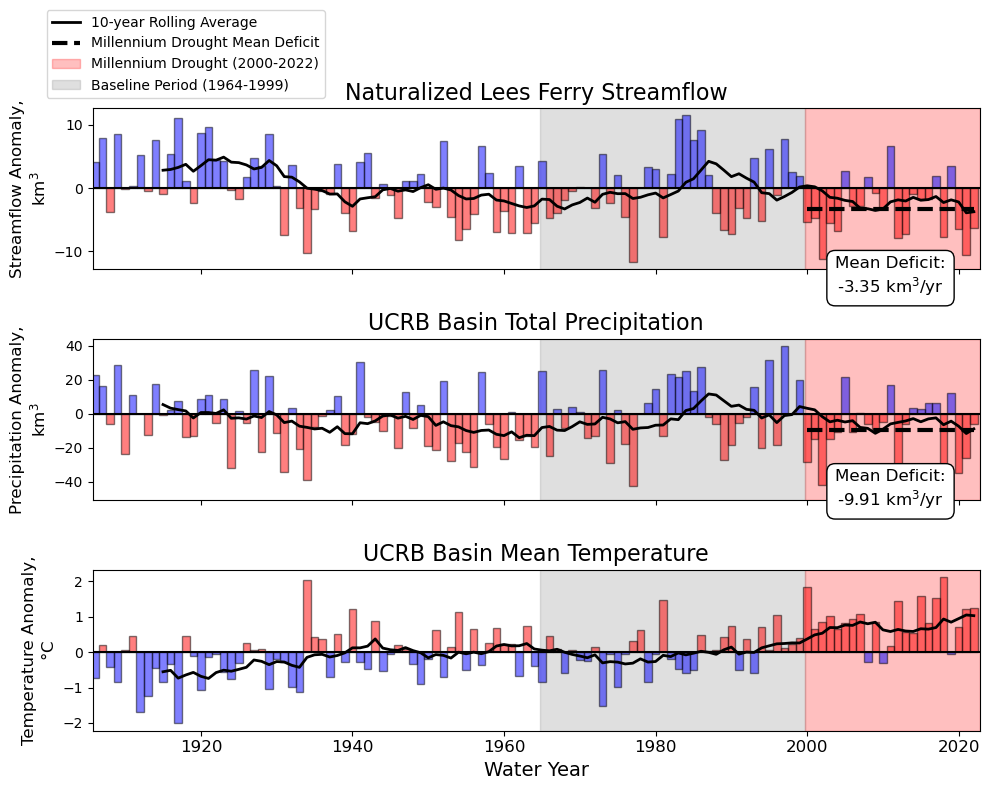

In [160]:
plt.style.use('default')
all_dates = pd.date_range('1895-10-01','2022-10-01', freq='1Y')
fig, axs = plt.subplots(nrows=3, figsize=(10,8), tight_layout=True, sharex=True)

ax = axs[0]
flow_anomaly = ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].loc[dt.date(1963,1,1):dt.date(1999,1,1)].mean()
# create a linear regression for the flow_anomaly
slope1, intercept1, _,_,_ = stats.linregress(flow_anomaly.index.year,flow_anomaly.values)
# add bar plot of ucrb_naturalized_streamflow[annual_flow_km3]
ax.bar(flow_anomaly[flow_anomaly>=0].index, flow_anomaly[flow_anomaly>=0], width=365.25, color='blue',ec='k', alpha=0.5)
ax.bar(flow_anomaly[flow_anomaly<0].index, flow_anomaly[flow_anomaly<0], width=365.25, color='red',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(flow_anomaly.index, flow_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(flow_anomaly.index , slope1*flow_anomaly.index.year + intercept1, ls='--',color='k', label='Best Fit Line', lw=2)

# runoff_ratio = ucrb_naturalized_streamflow_tmp['annual_flow_km3']/annual_p_km3['p_km3'].sel(WY=slice(1906,2022))

# ax3.plot(ucrb_naturalized_streamflow.index,runoff_ratio.rolling(10).mean(), color='k', lw=2, ls='dotted')
# ax3.set_ylabel('Runoff Ratio', color='black', size=12)
# ax3.set_ylim(runoff_ratio.rolling(10).mean().mean()-0.05,runoff_ratio.rolling(10).mean().mean()+0.05)
# # set ax3 y-ticks to be rounded to 2 decimal places
# ax3.set_yticklabels([f"{i:.2f}" for i in ax3.get_yticks()])
# ax3.tick_params(axis='y', labelcolor='black', labelsize=12)
# add a horizontal line for the mean flow anomaly from 2000-2022 spanning the years 2000-2022
ax.plot([dt.date(2000,1,1), dt.date(2022,1,1)],
        [flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean(),flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean()],
        color='k', ls='--', lw=3, label='Millennium Drought Mean Deficit')
# add a text box for the value of the flow anomaly from 2000-2022
ax.text(dt.date(2011,1,1), -14,
        f"Mean Deficit:\n{flow_anomaly.loc[dt.date(2000,1,1):dt.date(2022,1,1)].mean():.2f} km$^3$/yr", size=12,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Streamflow Anomaly,\nkm$^3$', size=12)
ax.set_title('Naturalized Lees Ferry Streamflow', size=16)
ax.set_xlim()

# plot precipitation
ax = axs[1]
precip_anomaly = (annual_p_km3['p_km3'].sel(WY=slice(1906,2022))-annual_p_km3['p_km3'].sel(WY=slice(1963,1999)).mean()).to_pandas()
precip_anomaly_with_dates = precip_anomaly.copy()
precip_anomaly_with_dates.index = all_dates[10:]
# create a linear regression for the precip_anomaly
slope2, intercept2, _,_,_ = stats.linregress(precip_anomaly.index,precip_anomaly)

# add bar plot of ucrb_naturalized_streamflow[annual_flow_km3]
ax.bar(precip_anomaly_with_dates[precip_anomaly_with_dates>=0].index, precip_anomaly[precip_anomaly>=0], width=365.25, color='blue',ec='k', alpha=0.5)
ax.bar(precip_anomaly_with_dates[precip_anomaly_with_dates<0].index, precip_anomaly[precip_anomaly<0], width=365.25, color='red',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(all_dates[10:], precip_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(all_dates[10:], slope2*precip_anomaly.index + intercept2, ls='--',color='k', label='Best Fit Line', lw=2)
# add a horizontal line for the mean flow anomaly from 2000-2022 spanning the years 2000-2022
ax.plot([dt.date(2000,1,1), dt.date(2022,1,1)],
        [precip_anomaly.loc[2000:2022].mean(),precip_anomaly.loc[2000:2022].mean()],
        color='k', ls='--', lw=3, label='Millennium Drought Mean Deficit')
# add a text box for the value of the flow anomaly from 2000-2022
ax.text(dt.date(2011,1,1), -45,
        f"Mean Deficit:\n{precip_anomaly.loc[2000:2022].mean():.2f} km$^3$/yr", size=12,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Precipitation Anomaly,\nkm$^3$', size=12)
ax.set_title('UCRB Basin Total Precipitation',size=16)

# plot temperature
ax = axs[2]
temp_anomaly = (annual_t_mean['t_mean'].sel(WY=slice(1906,2022))-annual_t_mean['t_mean'].sel(WY=slice(1963,1999)).mean()).to_pandas()
temp_anomaly_with_dates = temp_anomaly.copy()
temp_anomaly_with_dates.index = all_dates[10:]
# create a linear regression for the temp_anomaly
slope3, intercept3, _,_,_ = stats.linregress(temp_anomaly.index,temp_anomaly)

# add bar plot of temp_anomaly
ax.bar(temp_anomaly_with_dates[temp_anomaly_with_dates>=0].index, temp_anomaly[temp_anomaly>=0], width=365.25, color='red',ec='k', alpha=0.5)
ax.bar(temp_anomaly_with_dates[temp_anomaly_with_dates<0].index, temp_anomaly[temp_anomaly<0], width=365.25, color='blue',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(all_dates[10:], temp_anomaly.rolling(10).mean(), color='k', linewidth=2, label='10-year Rolling Average')
# add a trend line to the plot
# ax.plot(all_dates[10:], slope3*temp_anomaly.index + intercept3, ls='--',color='k', label='Best Fit Line', lw=2)
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Temperature Anomaly,\n$\degree$C', size=12)
ax.set_title('UCRB Basin Mean Temperature', size=16)
ax.set_xlabel('Water Year', size=14)
# increase the size of the x-axis tick labels
ax.tick_params(axis='x', which='major', labelsize=12)
for ax in axs:
    ax.axvspan(dt.date(1999,10,1),dt.date(2022,10,1),color='red',alpha=0.25, label='Millennium Drought (2000-2022)',zorder=0)
    ax.axvspan(dt.date(1964,10,1),dt.date(1999,10,1),color='grey',alpha=0.25, label='Baseline Period (1964-1999)',zorder=0)
    ax.set_xlim(dt.date(1905,10,1),dt.date(2022,10,1))
    
    # create a new legend for the vertical lines
    ax2 = ax.twinx()
    # add a vertical line at 2000 and label start of millennium drought
#     ax2.axvline(dt.date(1999,10,1), color='magenta', ls='--', lw=2, label='Millennium Drought Onset')
    # add a vertical line at 1962 and label Lake Powell filling
#     ax2.axvline(dt.date(1964,10,1), color='magenta', ls=':', lw=2,  label='Lake Powell Filling')
    # add a vertical line at 1922 and label Colorado River Compact
#     ax2.axvline(dt.date(1922,10,1), color='magenta', ls='-.', lw=2,  label='Colorado River Compact')
    ax2.axis('off')
    
    if ax == axs[0]:
        ax.legend(bbox_to_anchor=(-0.06, 1.02, 1, 0.2), loc="lower left",)  
        # ax2.legend(bbox_to_anchor=(1, 1.02), loc="lower right",)

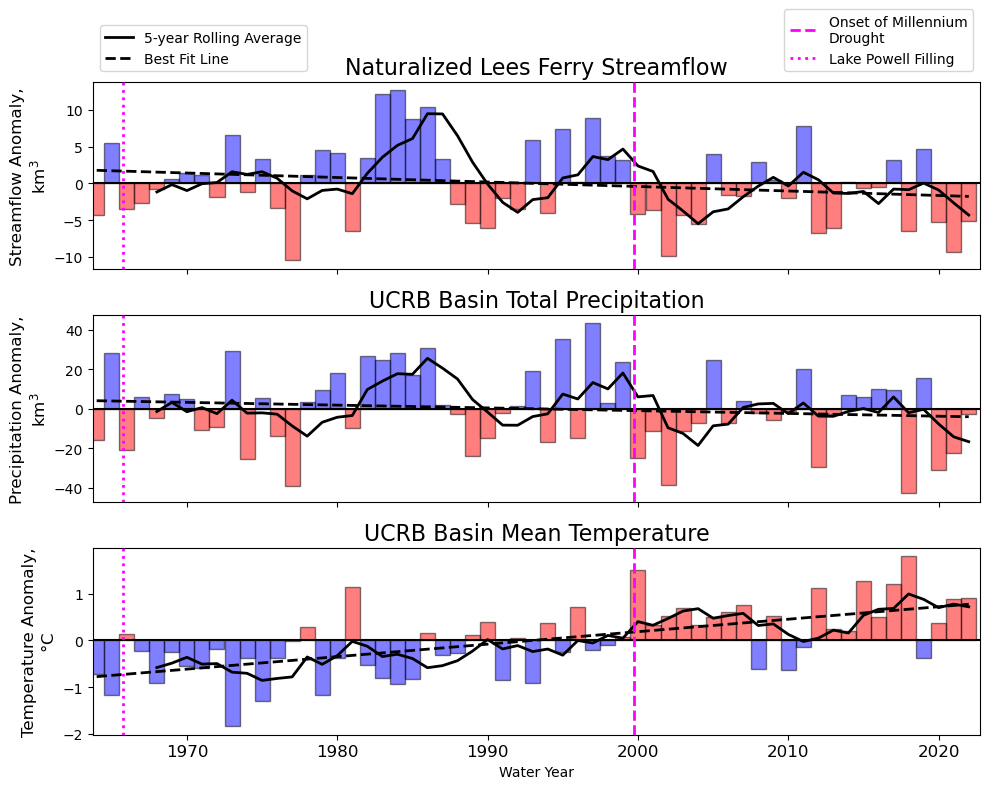

In [162]:
plt.style.use('default')
fig, axs = plt.subplots(nrows=3, figsize=(10,8), tight_layout=True, sharex=True)

ax = axs[0]
flow_anomaly = ucrb_naturalized_streamflow['annual_flow_km3'].loc[dt.date(1964,1,1):]-ucrb_naturalized_streamflow['annual_flow_km3'].loc[dt.date(1964,1,1):].mean()
# create a linear regression for the flow_anomaly
slope1, intercept1, _,_,_ = stats.linregress(flow_anomaly.index.year,flow_anomaly.values)
# add bar plot of ucrb_naturalized_streamflow[annual_flow_km3]
ax.bar(flow_anomaly[flow_anomaly>=0].index, flow_anomaly[flow_anomaly>=0], width=365.25, color='blue',ec='k', alpha=0.5)
ax.bar(flow_anomaly[flow_anomaly<0].index, flow_anomaly[flow_anomaly<0], width=365.25, color='red',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(flow_anomaly.index, flow_anomaly.rolling(5).mean(), color='k', linewidth=2, label='5-year Rolling Average')
# add a trend line to the plot
ax.plot(flow_anomaly.index , slope1*flow_anomaly.index.year + intercept1, ls='--',color='k', label='Best Fit Line', lw=2)
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Streamflow Anomaly,\nkm$^3$', size=12)
ax.set_title('Naturalized Lees Ferry Streamflow', size=16)
ax.set_xlim()

# plot precipitation
ax = axs[1]
precip_anomaly = (annual_p_km3.sel(WY=slice(1964,2022))['p_km3']-annual_p_km3.sel(WY=slice(1964,2022))['p_km3'].mean()).to_pandas()
precip_anomaly_with_dates = precip_anomaly.copy()
precip_anomaly_with_dates.index = all_dates[68:]
# create a linear regression for the precip_anomaly
slope2, intercept2, _,_,_ = stats.linregress(precip_anomaly.index,precip_anomaly)

# add bar plot of ucrb_naturalized_streamflow[annual_flow_km3]
ax.bar(precip_anomaly_with_dates[precip_anomaly_with_dates>=0].index, precip_anomaly[precip_anomaly>=0], width=365.25, color='blue',ec='k', alpha=0.5)
ax.bar(precip_anomaly_with_dates[precip_anomaly_with_dates<0].index, precip_anomaly[precip_anomaly<0], width=365.25, color='red',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(all_dates[68:], precip_anomaly.rolling(5).mean(), color='k', linewidth=2, label='5-year Rolling Average')
# add a trend line to the plot
ax.plot(all_dates[68:], slope2*precip_anomaly.index + intercept2, ls='--',color='k', label='Best Fit Line', lw=2)
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Precipitation Anomaly,\nkm$^3$', size=12)
ax.set_title('UCRB Basin Total Precipitation',size=16)

# plot temperature
ax = axs[2]
temp_anomaly = (annual_t_mean.sel(WY=slice(1964,2022))['t_mean']-annual_t_mean.sel(WY=slice(1964,2022))['t_mean'].mean()).to_pandas()
temp_anomaly_with_dates = temp_anomaly.copy()
temp_anomaly_with_dates.index = all_dates[68:]
# create a linear regression for the temp_anomaly
slope3, intercept3, _,_,_ = stats.linregress(temp_anomaly.index,temp_anomaly)

# add bar plot of temp_anomaly
ax.bar(temp_anomaly_with_dates[temp_anomaly_with_dates>=0].index, temp_anomaly[temp_anomaly>=0], width=365.25, color='red',ec='k', alpha=0.5)
ax.bar(temp_anomaly_with_dates[temp_anomaly_with_dates<0].index, temp_anomaly[temp_anomaly<0], width=365.25, color='blue',ec='k', alpha=0.5)
# add a 10 year moving average line to the plot
ax.plot(all_dates[68:], temp_anomaly.rolling(5).mean(), color='k', linewidth=2, label='5-year Rolling Average')
# add a trend line to the plot
ax.plot(all_dates[68:], slope3*temp_anomaly.index + intercept3, ls='--',color='k', label='Best Fit Line', lw=2)
# add a 0 line
ax.axhline(0, color='k')
# set the labels
ax.set_ylabel('Temperature Anomaly,\n$\degree$C', size=12)
ax.set_title('UCRB Basin Mean Temperature', size=16)
ax.set_xlabel('Water Year')
# increase the size of the x-axis tick labels
ax.tick_params(axis='x', which='major', labelsize=12)
for ax in axs:
    ax.set_xlim(dt.date(1963,10,1),dt.date(2022,10,1))
    
    # create a new legend for the vertical lines
    ax2 = ax.twinx()
    # add a vertical line at 2000 and label start of millennium drought
    ax2.axvline(dt.date(1999,10,1), color='magenta', ls='--', lw=2, label='Onset of Millennium\nDrought')
    # add a vertical line at 1962 and label Lake Powell filling
    ax2.axvline(dt.date(1965,10,1), color='magenta', ls=':', lw=2,  label='Lake Powell Filling')
    # add a vertical line at 1922 and label Colorado River Compact
    # ax2.axvline(dt.date(1922,10,1), color='magenta', ls='-.', lw=2,  label='Colorado River Compact')
    ax2.axis('off')
    
    if ax == axs[0]:
        ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",)  
        ax2.legend(bbox_to_anchor=(1, 1.02), loc="lower right",)

# <a id='toc5_'></a>[Let's change to focusing on our HCDN basins](#toc0_)

Pull in the HCDN basins as a geodataframe

In [163]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]


Create a data array to add in the basin area to our dataset

In [164]:
area_da = hcdn_basins.basin_area.to_xarray()
area_da = area_da.rename({'gage':'site_no'})

Create a data array to add in centroid lat and long to our dataset

In [165]:
x_vals = hcdn_basins.geometry.centroid.x.to_xarray()
x_vals.name = 'x'
y_vals = hcdn_basins.geometry.centroid.y.to_xarray()
y_vals.name = 'y'
coords_da =  xr.merge([x_vals,y_vals])
coords_da = coords_da.rename({'gage':'site_no'})


/tmp/ipykernel_3255/4223117852.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_vals = hcdn_basins.geometry.centroid.x.to_xarray()
/tmp/ipykernel_3255/4223117852.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_vals = hcdn_basins.geometry.centroid.y.to_xarray()


Open the UCRB dem and derive basin mean elevations for each basin...

In [166]:
ucrb_dem = rxr.open_rasterio('../basin_characteristics/ucrb_dem_150m.tif')
basin_mean_elevations = {}
for gage in hcdn_basins.index:
    basin = hcdn_basins[hcdn_basins.index==gage]
    clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
    clipped_dem_ma = clipped_dem.where(clipped_dem>0)
    basin_mean_elevations[gage] = clipped_dem_ma.mean().values

Then add this to a data array to pull into our entire dataset

In [202]:
elevation_da = xr.Dataset(basin_mean_elevations).to_array()
elevation_da.name='elevation'
elevation_da = elevation_da.rename({'variable':'site_no'})

Derive basin elevation ranges

In [203]:
basin_elevation_range = {}
for gage in hcdn_basins.index:
    basin = hcdn_basins[hcdn_basins.index==gage]
    clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
    clipped_dem_ma = clipped_dem.where(clipped_dem>0)
    basin_elevation_range[gage] = clipped_dem_ma.max().values - clipped_dem_ma.min().values 

Then add this to a data array to pull into our entire dataset

In [204]:
elevation_range_da = xr.Dataset(basin_elevation_range).to_array()
elevation_range_da.name='elevation_range'
elevation_range_da = elevation_range_da.rename({'variable':'site_no'})

Add precipitation

In [205]:
# Pull in HCDN precip data
hcdn_prism_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')
hcdn_prism_seasonal_ppt = hcdn_prism_seasonal_ppt.sel(dim_1='ppt')
hcdn_prism_seasonal_ppt = hcdn_prism_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})

hcdn_prism_seasonal_ppt['year'] = hcdn_prism_seasonal_ppt.month.dt.year.where(hcdn_prism_seasonal_ppt.month.dt.month<10, hcdn_prism_seasonal_ppt.month.dt.year+1)
hcdn_prism_annual_ppt = hcdn_prism_seasonal_ppt.groupby('year').sum()

Do the same using the aspect tif file. 

In [206]:
ucrb_aspect = rxr.open_rasterio('../basin_characteristics/ucrb_aspect.tif')
basin_aspect_classification = {}
for gage in hcdn_basins.index:
    basin = hcdn_basins[hcdn_basins.index==gage]
    # Clip file to basin geometry
    clipped_aspect = ucrb_aspect.rio.clip(basin.geometry).squeeze()
    # Mask out values less than 0
    clipped_aspect_ma = clipped_aspect.where(clipped_aspect>=0)
    # Create omni-directional masks
    north = clipped_aspect_ma.where((clipped_aspect_ma>=270) | (clipped_aspect_ma<90))
    south = clipped_aspect_ma.where((clipped_aspect_ma>=90) & (clipped_aspect_ma<270))
    # west = clipped_aspect_ma.where((clipped_aspect_ma>=225) & (clipped_aspect_ma<315))
    # east = clipped_aspect_ma.where((clipped_aspect_ma>=45) & (clipped_aspect_ma<135))
    north_fraction = north.count()/clipped_aspect_ma.count()
    south_fraction = south.count()/clipped_aspect_ma.count()
    # west_fraction = west.count()/clipped_aspect_ma.count()
    # east_fraction = east.count()/clipped_aspect_ma.count()
    basin_aspect_classification[gage] = (float(north_fraction.values),float(south_fraction.values))
                                        #  float(west_fraction.values),float(east_fraction.values))

In [207]:
aspect_df = pd.DataFrame.from_dict(basin_aspect_classification).T
aspect_df = aspect_df.rename(columns={0:'north',1:'south'})#,2:'west',3:'east'})
aspect_df['aspect'] = aspect_df.idxmax(axis=1)
# aspect_df['north'] = (aspect_df['north'] - aspect_df['north'].min())/(aspect_df['north'].max() - aspect_df['north'].min())
# aspect_df['south'] = (aspect_df['south'] - aspect_df['south'].min())/(aspect_df['south'].max() - aspect_df['south'].min())
aspect_ds = aspect_df.to_xarray()
aspect_ds = aspect_ds.rename({'index':'site_no'})

Pull in our HCDN flow data and convert to mm per day units

In [208]:
# Pull in streamflow data and merge in new datarrays
hcdn_streamflow_daily_ds = xr.open_dataset('../data/streamflowdata/hcdn_daily_q.nc')
hcdn_streamflow_daily_ds['site_no'] = ['0'+str(site) for site in hcdn_streamflow_daily_ds['site_no'].values]

hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(area_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(elevation_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(aspect_ds)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(elevation_range_da)
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(coords_da)
# Calculate flow rates in terms of basin-normalized mm/day from cubic meters per day
hcdn_streamflow_daily_ds['q_mm_day'] = hcdn_streamflow_daily_ds['00060_Mean'] * 1000 / hcdn_streamflow_daily_ds.basin_area
# Drop bad basins
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.where(~hcdn_streamflow_daily_ds.site_no.isin(['09306242','09378170','09378630']),drop=True)

# Add water year back in 
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.drop('WY')
wy_da = hcdn_streamflow_daily_ds.date.dt.year.where(hcdn_streamflow_daily_ds.date.dt.month<10, hcdn_streamflow_daily_ds.date.dt.year+1)
wy_da.name = 'WY'
hcdn_streamflow_daily_ds = hcdn_streamflow_daily_ds.merge(wy_da)

# Derive summer only mean flows 
hcdn_q_summer_ds = hcdn_streamflow_daily_ds.where(hcdn_streamflow_daily_ds.date.dt.month.isin([7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_summer_ds = hcdn_q_summer_ds.sortby('date')
hcdn_q_summer_ds = hcdn_q_summer_ds.where(hcdn_q_summer_ds['q_mm_day']>0)
hcdn_q_summer_ds = hcdn_q_summer_ds.rename({'q_mm_day':'q_mm_day_summer'})
hcdn_q_summer_mean_ds = hcdn_q_summer_ds.groupby('date.year').mean().where(hcdn_q_summer_ds['00060_Mean'].groupby('date.year').count()>85)

# Derive the mean Spring + Summer flow for AMJJAS
hcdn_q_spring_summer_ds = hcdn_streamflow_daily_ds.where(hcdn_streamflow_daily_ds.date.dt.month.isin([4,5,6,7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_spring_summer_ds = hcdn_q_spring_summer_ds.sortby('date')
hcdn_q_spring_summer_ds = hcdn_q_spring_summer_ds.where(hcdn_q_spring_summer_ds['q_mm_day']>0)
# Groupby year but filter out years with less than 173 days of streamflow data
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_ds.groupby('date.year').mean().where(hcdn_q_spring_summer_ds['00060_Mean'].groupby('date.year').count()>173)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_annual_ppt).squeeze()
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.where(~hcdn_q_spring_summer_mean_ds.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_q_summer_mean_ds['q_mm_day_summer'])
hcdn_q_spring_summer_mean_ds['q_mm'] = hcdn_q_spring_summer_mean_ds['q_mm_day']*183 # total q in mm over the period
# Normalize these values for basin-to-basin comparison
hcdn_q_spring_summer_norm = (hcdn_q_spring_summer_mean_ds-hcdn_q_spring_summer_mean_ds.mean(dim='year'))/hcdn_q_spring_summer_mean_ds.std(dim='year')

# Save new daily dataset 
# hcdn_streamflow_daily_ds.to_netcdf('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')

In [252]:
# add precip to annual flows
hcdn_streamflow_ds = hcdn_streamflow_daily_ds.groupby(hcdn_streamflow_daily_ds.WY).mean().where(hcdn_streamflow_daily_ds['00060_Mean'].groupby(hcdn_streamflow_daily_ds.WY).count()>350)
hcdn_streamflow_ds = hcdn_streamflow_ds.merge(hcdn_prism_annual_ppt).squeeze()
hcdn_streamflow_ds = hcdn_streamflow_ds.where(~hcdn_streamflow_ds.site_no.isin(['09306242','09378170','09378630']),drop=True).drop_dims(['year'])
# establish q_mm by multiplying by the count of valid data for each water year
hcdn_streamflow_ds['q_mm'] = hcdn_streamflow_ds['q_mm_day']*hcdn_streamflow_daily_ds['00060_Mean'].groupby(hcdn_streamflow_daily_ds.WY).count()
# save to netcdf
# hcdn_streamflow_ds.to_netcdf('../data/streamflowdata/hcdn_basin_annual_q.nc')

Create a plot to visualize the timeline of each basins gage network compared to Lee's Ferry

Text(0.02, 0.5, 'Gage ID')

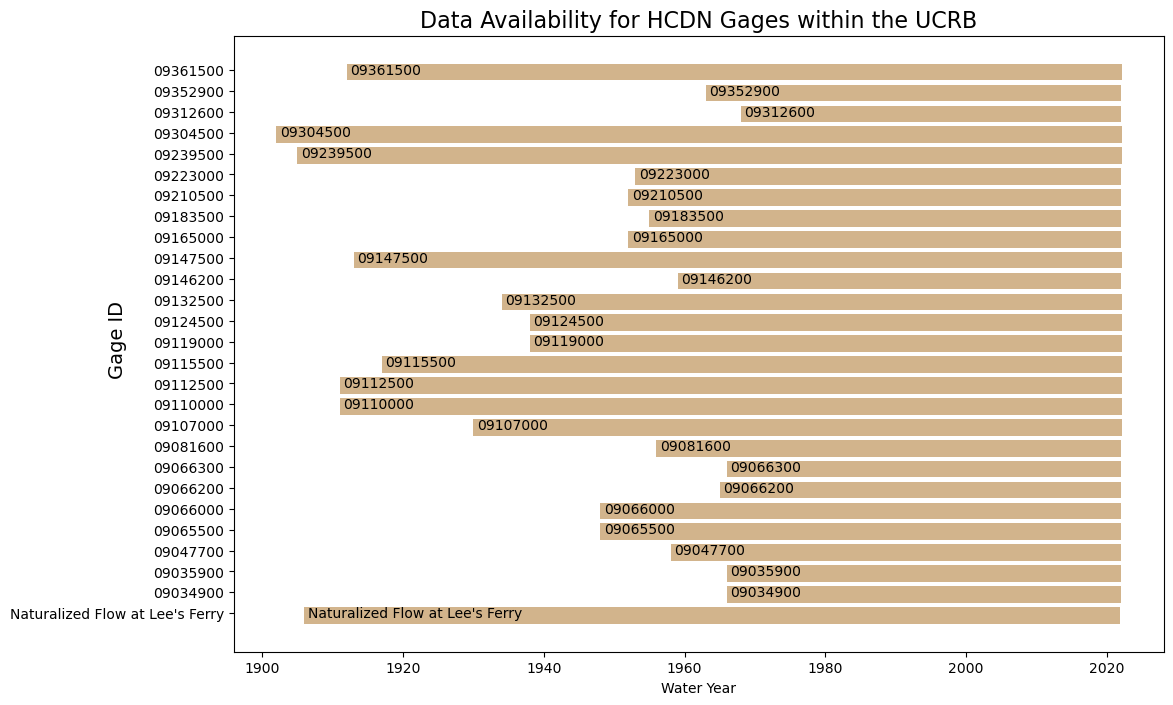

In [38]:
source = pd.DataFrame([{"data": "Naturalized Flow at Lee's Ferry","start": '1906-01-01', "end": '2021-09-30'},])
for i,site in enumerate(hcdn_q_spring_summer_mean_ds.site_no):
    min_year = int(hcdn_q_spring_summer_mean_ds.sel(site_no=site).WY.min().values)
    max_year = int(hcdn_q_spring_summer_mean_ds.sel(site_no=site).WY.max().values)
    source.loc[i+1] = {"data": str(site.values),"start": f'{min_year}-09-30', "end": f'{max_year}-10-01'}

source['start'] = pd.to_datetime(source['start'])
source['end'] = pd.to_datetime(source['end'])
source['diff'] = source['end'] - source['start']
 
# Declaring a figure "gnt"
fig, ax = plt.subplots(figsize=(12,8))
gnt=ax 
# Need to fix hidden tick labels
# https://stackoverflow.com/questions/43673659/matplotlib-not-showing-first-label-on-x-axis-for-the-bar-plot
 
y_tick_labels = source.data.values
y_pos = np.arange(len(y_tick_labels))
 
gnt.set_yticks(y_pos)
gnt.set_yticklabels(y_tick_labels)
 
 
# https://sparkbyexamples.com/python/iterate-over-rows-in-pandas-dataframe/
# https://www.tutorialspoint.com/plotting-dates-on-the-x-axis-with-python-s-matplotlib
# https://matplotlib.org/stable/gallery/color/named_colors.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
# https://www.geeksforgeeks.org/how-to-annotate-matplotlib-scatter-plots
for index, row in source.sort_values(by='start', ascending=True).iterrows():
    start_year = int(row.start.strftime("%Y"))
    duration = row['diff'].days/365
    gnt.broken_barh([(start_year, duration)], 
                    (index-0.5,0.8), 
                    facecolors =('tan'),
                   label=row.data)
    gnt.text(start_year+0.5, index-0.2, row.data)
gnt.set_xlabel('Water Year')
gnt.set_title('Data Availability for HCDN Gages within the UCRB', size=16)
# add a y-label to fig
# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
fig.text(0.02, 0.5, 'Gage ID', va='center', rotation='vertical', size=14)

Create a simple plot of basin-to-basin correlation of spring+summer mean streamflow

<AxesSubplot: xlabel='site_no', ylabel='site_no'>

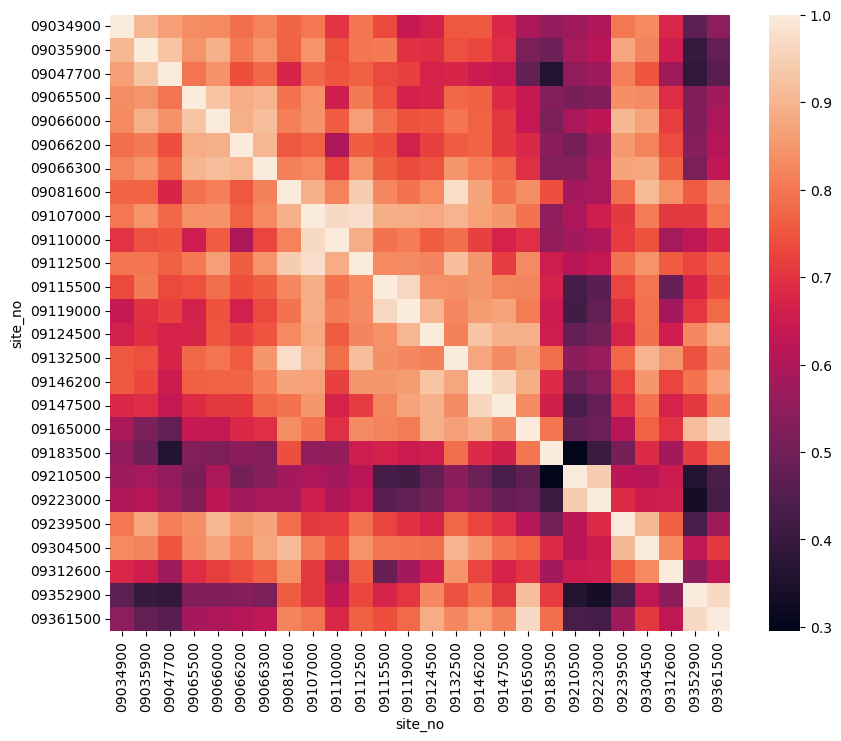

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(hcdn_q_spring_summer_mean_ds['00060_Mean'].to_pandas().corr(), ax=ax)

Plot basin mean elevation against mean $Q_{SpSu}$ 

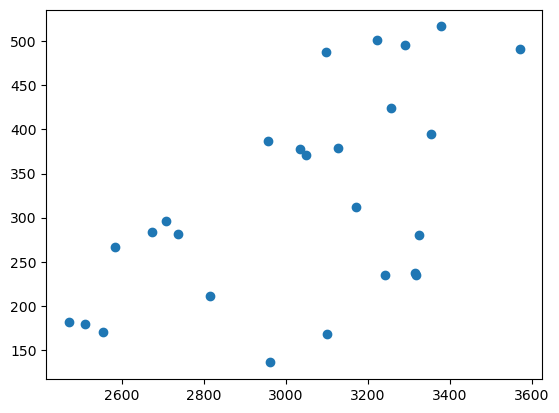

In [244]:
# drop years where streamflow is in the bottom 10% of all years at each site
hcdn_streamflow_ds_filtered = hcdn_streamflow_ds.where((hcdn_streamflow_ds['q_mm'] > hcdn_streamflow_ds['q_mm'].quantile(0.10)) & 
                                                (hcdn_streamflow_ds['q_mm'] < hcdn_streamflow_ds['q_mm'].quantile(0.90)), drop=True)
hcdn_streamflow_ds_mean = hcdn_streamflow_ds_filtered.mean(dim='WY')
plt.scatter(hcdn_streamflow_ds_mean.elevation, hcdn_streamflow_ds_mean['q_mm'])                                                                      

In [257]:
df = pd.DataFrame({'elevation':hcdn_streamflow_ds_mean.elevation.to_pandas(), 'q_mm':hcdn_streamflow_ds_mean['q_mm'].to_pandas()})


# Define the bins and labels for elevation groups
labels = [1,0,2]  # The labels for each bin

# Use pd.cut() to categorize elevation and create a new column
df['elevation_group'] = pd.cut(df['elevation'], bins=3, labels=labels, right=False)

# Print the resulting DataFrame
df

,elevation,q_mm,elevation_group
site_no,,,
09034900,3571.178223,491.246080,2
09035900,3355.654785,394.863615,2
09047700,3318.343994,235.031367,2
09065500,3379.909180,516.735512,2
09066000,3257.457031,424.441600,2
09066200,3290.367432,495.488773,2
09066300,3172.646240,311.519436,0
09081600,3098.400391,488.352344,0
09107000,3324.467285,280.006722,2


Text(0.5, 1.0, 'Do North facing, high elevation, small basins have highest RR?')

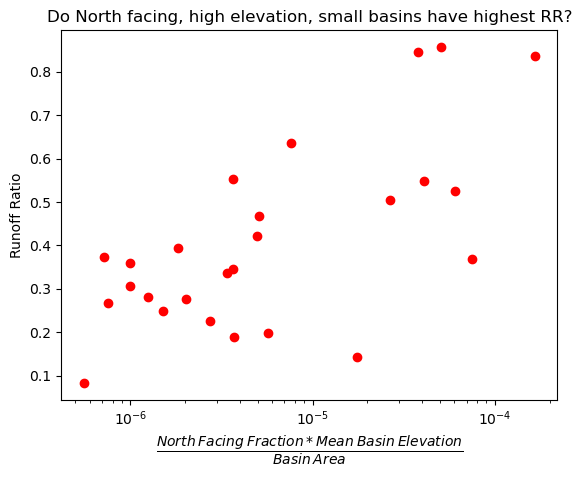

In [246]:
fig, ax = plt.subplots()
for site in hcdn_q_spring_summer_mean_ds.site_no:
    # ax.scatter(hcdn_q_spring_summer_mean_ds['north'].sel(site_no=site).max().values,
    #            hcdn_q_spring_summer_mean_ds['q_mm_day'].sel(site_no=site).mean().values,
    #            color='green',
    #            )
    ax.scatter(hcdn_q_spring_summer_mean_ds['north'].sel(site_no=site).max().values * hcdn_q_spring_summer_mean_ds['elevation'].sel(site_no=site).max().values/hcdn_q_spring_summer_mean_ds['basin_area'].sel(site_no=site).max().values,
               hcdn_q_spring_summer_mean_ds['q_mm'].sel(site_no=site).mean().values/hcdn_q_spring_summer_mean_ds['ppt'].sel(site_no=site).mean().values,
               color='red',
               )
# ax.scatter(ucrb_basin_boundary.area, (ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 / ucrb_basin_boundary.area.values[0] * 1000).mean())
ax.set_xscale('log')
ax.set_xlabel('$\dfrac{North\:Facing\:Fraction * Mean\:Basin\:Elevation}{Basin\:Area}$')
ax.set_ylabel('Runoff Ratio')
ax.set_title('Do North facing, high elevation, small basins have highest RR?')

Text(0.5, 23.52222222222222, 'Easting')

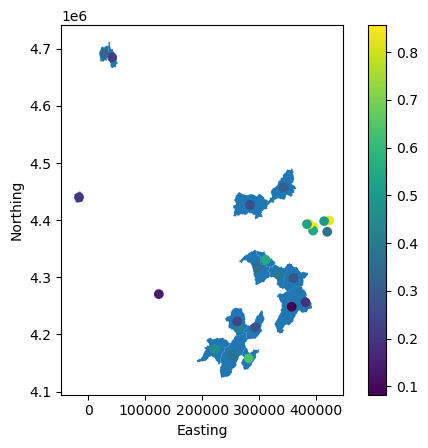

In [34]:
fig, ax = plt.subplots()
hcdn_basins.plot(ax=ax)
im = ax.scatter(hcdn_q_spring_summer_mean_ds['x'].mean(dim='year'),
           hcdn_q_spring_summer_mean_ds['y'].mean(dim='year'),
           c = hcdn_q_spring_summer_mean_ds['q_mm'].mean(dim='year').values/hcdn_q_spring_summer_mean_ds['ppt'].mean(dim='year').values,
            )
fig.colorbar(im, ax=ax, )
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')
# ax.set_title('Do North facing, high elevation, small basins have highest RR?')

Text(0.5, 23.52222222222222, 'Easting')

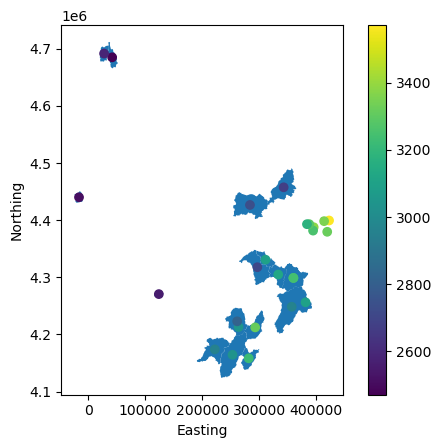

In [35]:
fig, ax = plt.subplots()
hcdn_basins.plot(ax=ax)
im = ax.scatter(hcdn_q_spring_summer_mean_ds['x'].mean(dim='year'),
           hcdn_q_spring_summer_mean_ds['y'].mean(dim='year'),
           c = hcdn_q_spring_summer_mean_ds['elevation'].mean(dim='year'),
            )
fig.colorbar(im, ax=ax, )
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')

Text(0.5, 1.0, 'Do high elevation basins have highest RR?')

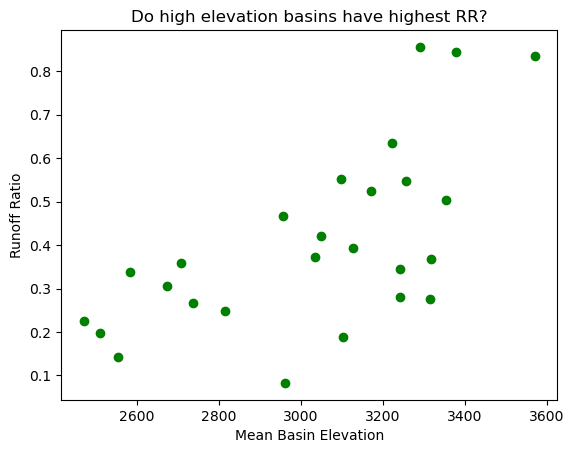

In [36]:
fig, ax = plt.subplots()
for site in hcdn_q_spring_summer_mean_ds.site_no:
    ax.scatter(hcdn_q_spring_summer_mean_ds['elevation'].sel(site_no=site).max().values,
                hcdn_q_spring_summer_mean_ds['q_mm'].sel(site_no=site).mean().values/hcdn_q_spring_summer_mean_ds['ppt'].sel(site_no=site).mean().values,
               color='green',
               )

ax.set_xlabel('Mean Basin Elevation')
ax.set_ylabel('Runoff Ratio')
ax.set_title('Do high elevation basins have highest RR?')

Text(0.5, 1.0, 'Do high elevation basins have highest Q$_{SpSu}$?')

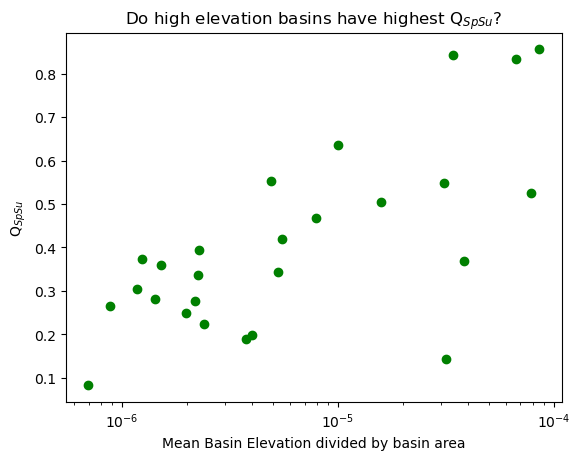

In [37]:
fig, ax = plt.subplots()

ax.scatter(hcdn_q_spring_summer_mean_ds['elevation_range'].mean(dim='year').values/hcdn_q_spring_summer_mean_ds['basin_area'].mean(dim='year').values,
           hcdn_q_spring_summer_mean_ds['q_mm'].mean(dim='year').values/hcdn_q_spring_summer_mean_ds['ppt'].mean(dim='year').values,
           color='green',
           )
ax.set_xscale('log')
ax.set_xlabel('Mean Basin Elevation divided by basin area')
ax.set_ylabel('Q$_{SpSu}$')
ax.set_title('Do high elevation basins have highest Q$_{SpSu}$?')

In [38]:
# west_basins = hcdn_q_spring_summer_mean_ds.where(hcdn_q_spring_summer_mean_ds.q_mm>0).sel(site_no=hcdn_q_spring_summer_mean_ds.site_no.isin(aspect_ds.where(aspect_ds.aspect=='west').dropna(dim='site_no').site_no.values))
# east_basins = hcdn_q_spring_summer_mean_ds.where(hcdn_q_spring_summer_mean_ds.q_mm>0).sel(site_no=hcdn_q_spring_summer_mean_ds.site_no.isin(aspect_ds.where(aspect_ds.aspect=='east').dropna(dim='site_no').site_no.values))
north_basins = hcdn_q_spring_summer_mean_ds.where(hcdn_q_spring_summer_mean_ds.q_mm>0).sel(site_no=hcdn_q_spring_summer_mean_ds.site_no.isin(aspect_ds.where(aspect_ds.aspect=='north').dropna(dim='site_no').site_no.values))
south_basins = hcdn_q_spring_summer_mean_ds.where(hcdn_q_spring_summer_mean_ds.q_mm>0).sel(site_no=hcdn_q_spring_summer_mean_ds.site_no.isin(aspect_ds.where(aspect_ds.aspect=='south').dropna(dim='site_no').site_no.values))

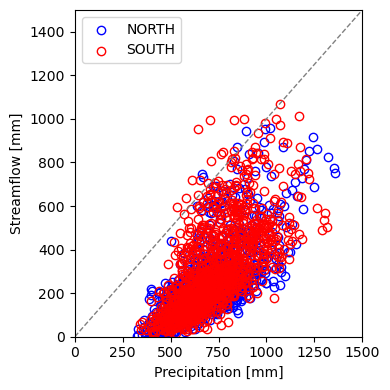

In [40]:
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)
aspect = [north_basins,
          south_basins]
labels = ['north','south']
colors = ['b','red']
for i,a_ds in enumerate(aspect):
    ax.scatter(a_ds.ppt,a_ds.q_mm, ec=colors[i], color= "#FFFFFF00", label=labels[i].upper())

ax.plot([0,1500],[0,1500],ls='--',color='grey',lw=1)
ax.set_ylim(0,1500)
ax.set_xlim(0,1500)
ax.set_ylabel('Streamflow [mm]')
ax.set_xlabel('Precipitation [mm]')
ax.legend()

### <a id='toc5_1_1_'></a>[Trying k-means clustering to identify clusters by elevation group](#toc0_)

In [146]:
# Make a tidy dataframe for clustering
tidy_df = north_basins[['q_mm','ppt','basin_area']].to_dataframe().reset_index()
q_elevation_array = tidy_df[['q_mm','ppt']].dropna().to_numpy()

In [147]:
# Make a tidy dataframe for clustering
tidy_df = hcdn_q_spring_summer_mean_ds[['q_mm','elevation','basin_area']].mean(dim='year').to_dataframe().reset_index()
q_elevation_array = tidy_df[['q_mm','elevation']].dropna().to_numpy()

In [149]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(q_elevation_array)

In [150]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
    )

In [151]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [152]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

 # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

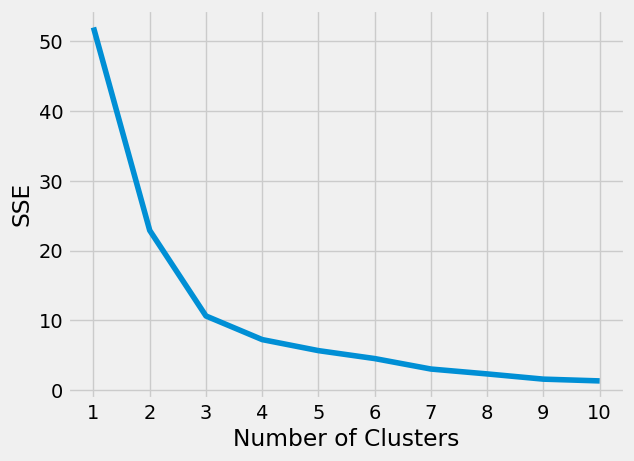

In [153]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [154]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
 )

kl.elbow

3

In [155]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

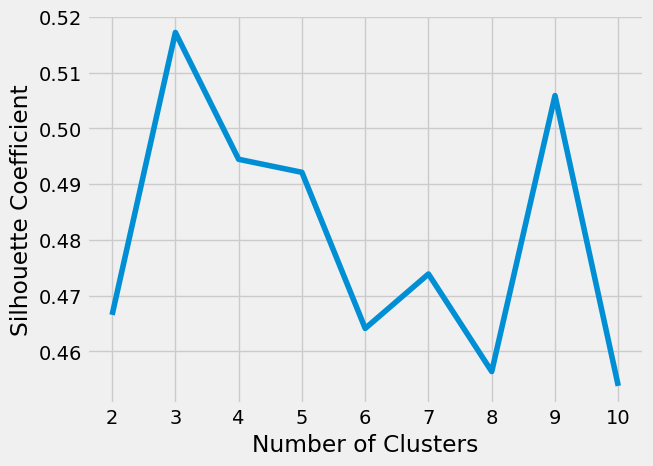

In [156]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [157]:
preprocessor = Pipeline(
     [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
     ]
 )

In [158]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=3,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

The Pipeline class can be chained to form a larger pipeline. Build an end-to-end k-means clustering pipeline by passing the "preprocessor" and "clusterer" pipelines to Pipeline:

In [159]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [160]:
pipe.fit(scaled_features)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

In [161]:
preprocessed_data = pipe["preprocessor"].transform(scaled_features)

predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.51691860627503

In [162]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(scaled_features),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

In [163]:
tiday_clustered_df = tidy_df.dropna().reset_index(drop=True).merge(pcadf['predicted_cluster'], left_index=True,right_index=True)

Decided to not use K-means, grouped by threshold values

In [251]:
df.rename(columns={'elevation_group':'predicted_cluster'}).reset_index()[['site_no','predicted_cluster']].to_csv('../data/geodata/basin_elevation_groups.csv')
# tiday_clustered_df[['site_no','predicted_cluster']].to_csv('../data/geodata/basin_elevation_groups_kmeans.csv')

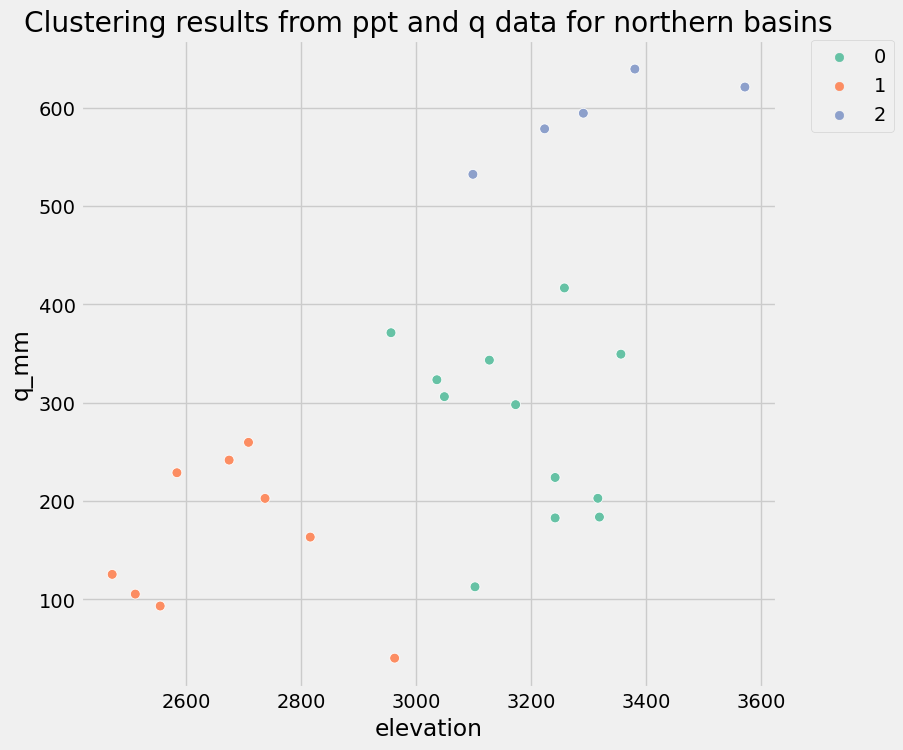

In [165]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    data=tiday_clustered_df,
    x="elevation",
    y="q_mm",
    s=50,
    hue="predicted_cluster",
    palette="Set2",
)

scat.set_title(
    "Clustering results from ppt and q data for northern basins"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

Location of clusters

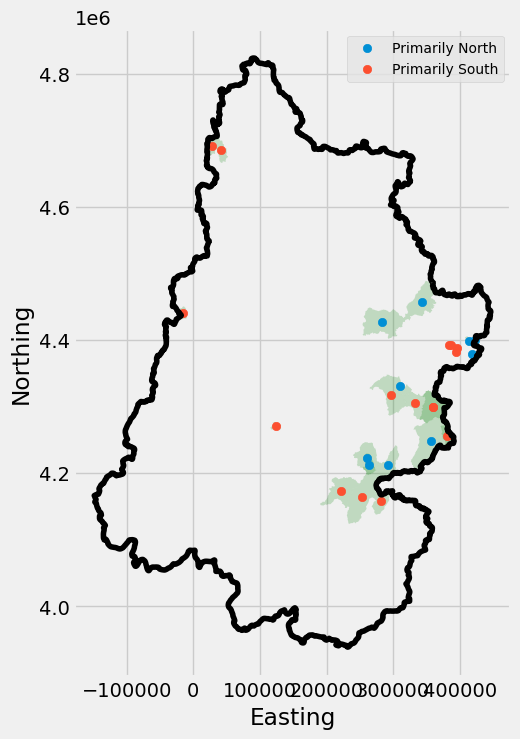

In [167]:
fig, ax = plt.subplots(figsize=(8,8))
plt.style.use('ggplot')
hcdn_basins.plot(ax=ax,alpha=0.2,color='green')
ucrb_basin_boundary.boundary.plot(ax=ax,color='k')
# ax.scatter(west_basins['x'].mean(dim='year'),
#            west_basins['y'].mean(dim='year'),
#             )
# # ax.scatter(east_basins['x'].mean(dim='year'),
# #            east_basins['y'].mean(dim='year'),
# #             )
ax.scatter(north_basins['x'].mean(dim='year'),
           north_basins['y'].mean(dim='year'),
           label='Primarily North'
            )
ax.scatter(south_basins['x'].mean(dim='year'),
           south_basins['y'].mean(dim='year'),
           label='Primarily South'
            )
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')
ax.legend()

# <a id='toc6_'></a>[Plot winter and spring precipitation against naturalized streamflow](#toc0_)

In [170]:
winter_spring_p = p_mean.where(p_mean.month.dt.month.isin([12,1,2,3,4,5])).groupby('WY').sum().sel(WY=slice(1906,2022))
winter_spring_p_stand_anom = (winter_spring_p-winter_spring_p.mean())/winter_spring_p.std()

winter_p = p_mean.where(p_mean.month.dt.month.isin([12,1,2])).groupby('WY').sum().sel(WY=slice(1906,2022))
winter_p_stand_anom = (winter_p-winter_p.mean())/winter_p.std()

spring_p = p_mean.where(p_mean.month.dt.month.isin([3,4,5])).groupby('WY').sum().sel(WY=slice(1906,2022))
spring_p_stand_anom = (spring_p-spring_p.mean())/spring_p.std()

summer_p = p_mean.where(p_mean.month.dt.month.isin([6,7,8])).groupby('WY').sum().sel(WY=slice(1906,2022))
summer_p_stand_anom = (summer_p-summer_p.mean())/summer_p.std()

In [173]:
def precipFlowLinReg(p, q, alternative='greater'):
    slope, intercept,r,_,_ = stats.linregress(p,q)
    return slope, intercept,r

Interesting to note the change in slope in the more recent dry periods. It is significantly steeper. Now want to replicate this in other basins?

In [186]:
rolling_windows = np.arange(1,21,1)
rolling_vals = {}
min_start_year = []
for window in rolling_windows:
    rolling_vals[window] = ucrb_naturalized_streamflow['annual_flow_km3'].rolling(window, center=False).mean()
    min_start_year.append(rolling_vals[window].idxmin() - window)

(3.0, 30.0)

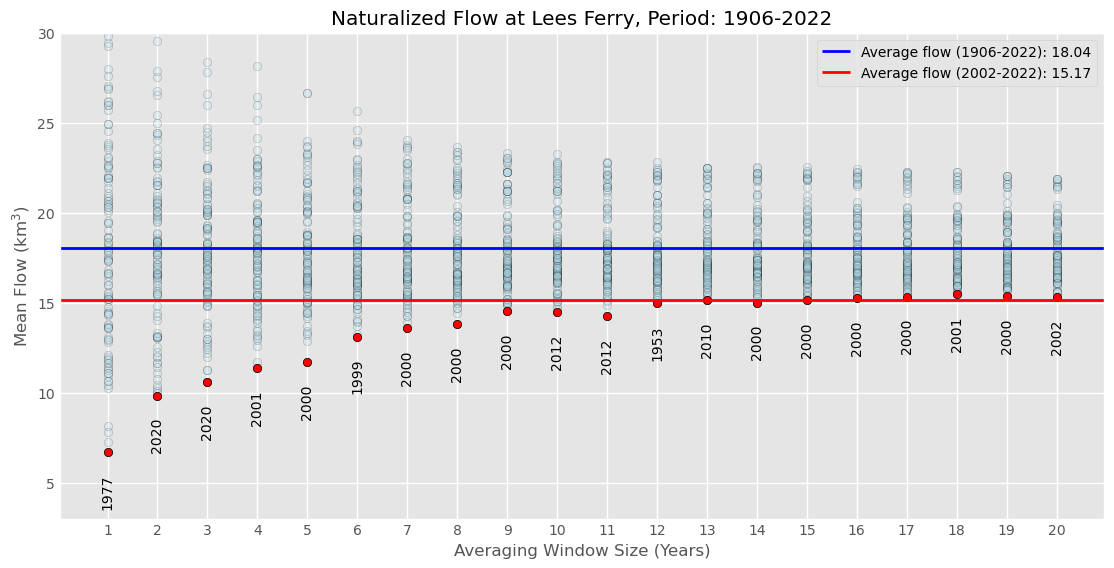

In [187]:
rolling_q_df = pd.DataFrame(rolling_vals)
plt.figure(figsize=(12,6))
for i,col in enumerate(rolling_q_df):
    plt.scatter(np.full(len(rolling_q_df.index),col), rolling_q_df[col], color='lightblue', alpha=0.2, ec='k')
    plt.scatter(col, rolling_q_df.loc[min_start_year[i]+col,col], color='red', ec='k')
    plt.text(x=col, 
            y=rolling_q_df.loc[min_start_year[i]+col,col]-3, 
            s=min_start_year[i]+1,
            rotation='vertical',
            horizontalalignment='center')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='blue',lw=2,
            label=f"Average flow (1906-2022): {round(ucrb_naturalized_streamflow['annual_flow_km3'].mean(),2)}")
plt.axhline(ucrb_naturalized_streamflow.loc[2002:2022,'annual_flow_km3'].mean(), color='red',lw=2,
            label=f"Average flow (2002-2022): {round(ucrb_naturalized_streamflow.loc[2002:2022,'annual_flow_km3'].mean(),2)}")
plt.title('Naturalized Flow at Lees Ferry, Period: 1906-2022')
plt.ylabel('Mean Flow (km$^3$)')
plt.xlabel('Averaging Window Size (Years)')
plt.legend()
plt.xticks(rolling_windows);
plt.ylim(3,30)

In [203]:
def cumulativeDeparture(df):
    return (df - ucrb_naturalized_streamflow['annual_flow_km3'].mean()).sum()


In [207]:
rolling_windows_sum = np.arange(1,21,1)
rolling_vals_sum = {}
max_start_year_sum = []
for window in rolling_windows:
    rolling_vals_sum[window] = ucrb_naturalized_streamflow['annual_flow_km3'].rolling(window, center=False).apply(lambda x: cumulativeDeparture(x))
    max_start_year_sum.append(rolling_vals_sum[window].idxmin() - window)

(-60.0, 0.0)

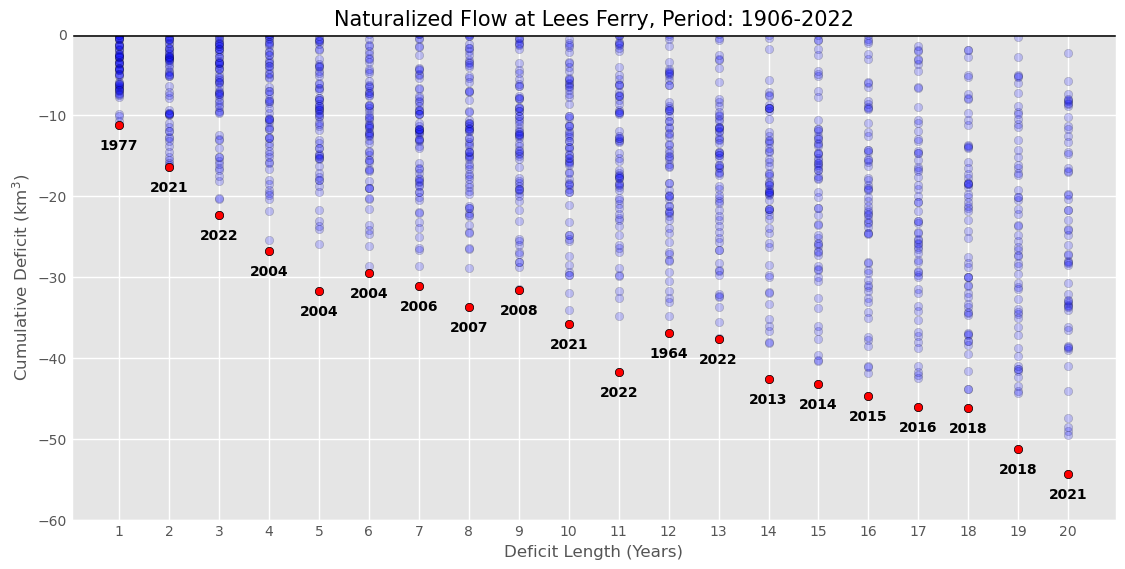

In [210]:
rolling_q_sum_df = pd.DataFrame(rolling_vals_sum)
plt.figure(figsize=(12,6))
plt.axhline(0, color='k',lw=4)
for i,col in enumerate(rolling_q_sum_df):
    plt.scatter(np.full(len(rolling_q_sum_df.index),col), rolling_q_sum_df[col], color='blue', alpha=0.2, ec='k')
    plt.scatter(col, rolling_q_sum_df.loc[max_start_year_sum[i]+col,col], color='red', ec='k')
    plt.text(x=col, 
             y=rolling_q_sum_df.loc[max_start_year_sum[i]+col,col]-3, 
             s=max_start_year_sum[i]+i+1,
             rotation='horizontal',
             horizontalalignment='center',
             # bold the text
             weight='bold')
plt.title('Naturalized Flow at Lees Ferry, Period: 1906-2022', size=15)
plt.ylabel('Cumulative Deficit (km$^3$)')
plt.xlabel('Deficit Length (Years)')
plt.xticks(rolling_windows_sum);
plt.ylim(0-60,0)

# <a id='toc7_'></a>[Working on mimicing the plots from Biederman et al.](#toc0_)

In [70]:
hcdn_prism_winter_ppt = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month==12)
hcdn_prism_winter_ppt = hcdn_prism_winter_ppt.groupby(hcdn_prism_winter_ppt.month.dt.year).mean()
hcdn_prism_winter_ppt = hcdn_prism_winter_ppt.rename({'ppt':'winter_ppt'})
hcdn_prism_winter_ppt = hcdn_prism_winter_ppt.where(hcdn_prism_winter_ppt>0)
new_dim = (hcdn_prism_winter_ppt.year + 1)
hcdn_prism_winter_ppt.coords[new_dim.name] = new_dim
hcdn_prism_winter_ppt = hcdn_prism_winter_ppt.where(hcdn_prism_winter_ppt.year!=2023,drop=True)

hcdn_prism_spring_ppt = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month==3)
hcdn_prism_spring_ppt = hcdn_prism_spring_ppt.groupby(hcdn_prism_spring_ppt.month.dt.year).mean()
hcdn_prism_spring_ppt = hcdn_prism_spring_ppt.rename({'ppt':'spring_ppt'})

hcdn_prism_wisp_ppt = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month.isin([12,3]))
hcdn_prism_wisp_ppt = hcdn_prism_wisp_ppt.groupby(hcdn_prism_wisp_ppt.month.dt.year).mean()*2
hcdn_prism_wisp_ppt = hcdn_prism_wisp_ppt.rename({'ppt':'wisp_ppt'})
new_dim = (hcdn_prism_wisp_ppt.year + 1)
hcdn_prism_wisp_ppt.coords[new_dim.name] = new_dim
hcdn_prism_wisp_ppt = hcdn_prism_wisp_ppt.where(hcdn_prism_wisp_ppt.year!=2023,drop=True)

hcdn_prism_summer_ppt = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month.isin([9]))
hcdn_prism_summer_ppt = hcdn_prism_summer_ppt.groupby(hcdn_prism_summer_ppt.month.dt.year).mean()
hcdn_prism_summer_ppt = hcdn_prism_summer_ppt.rename({'ppt':'summer_ppt'})

In [71]:
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_winter_ppt)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_spring_ppt)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_wisp_ppt, compat='override')
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_summer_ppt)

In [72]:
low_elevation_sites = tiday_clustered_df[tiday_clustered_df['predicted_cluster']==1].site_no.values
mid_elevation_sites = tiday_clustered_df[tiday_clustered_df['predicted_cluster']==0].site_no.values
high_elevation_sites = tiday_clustered_df[tiday_clustered_df['predicted_cluster']==2].site_no.values

In [73]:
# Plot all points and trend-line
def plotBestFit(ds, var1, var2, ax, color):
    df = ds[[var1, var2]].to_dataframe().dropna()
    m,b,r = precipFlowLinReg(df[var1],
                            df[var2]*30.425*3)
    x = [df[var1].min(),
        df[var1].max()]
    y = [df[var1].min()*m+b,
        df[var1].max()*m+b]
    ax.plot(x,y, color=color, lw=1)

### <a id='toc7_1_1_'></a>[Low Elevation Sites](#toc0_)

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(-0.02, 0.5, 'Q$_{SpSu}$ [mm]')

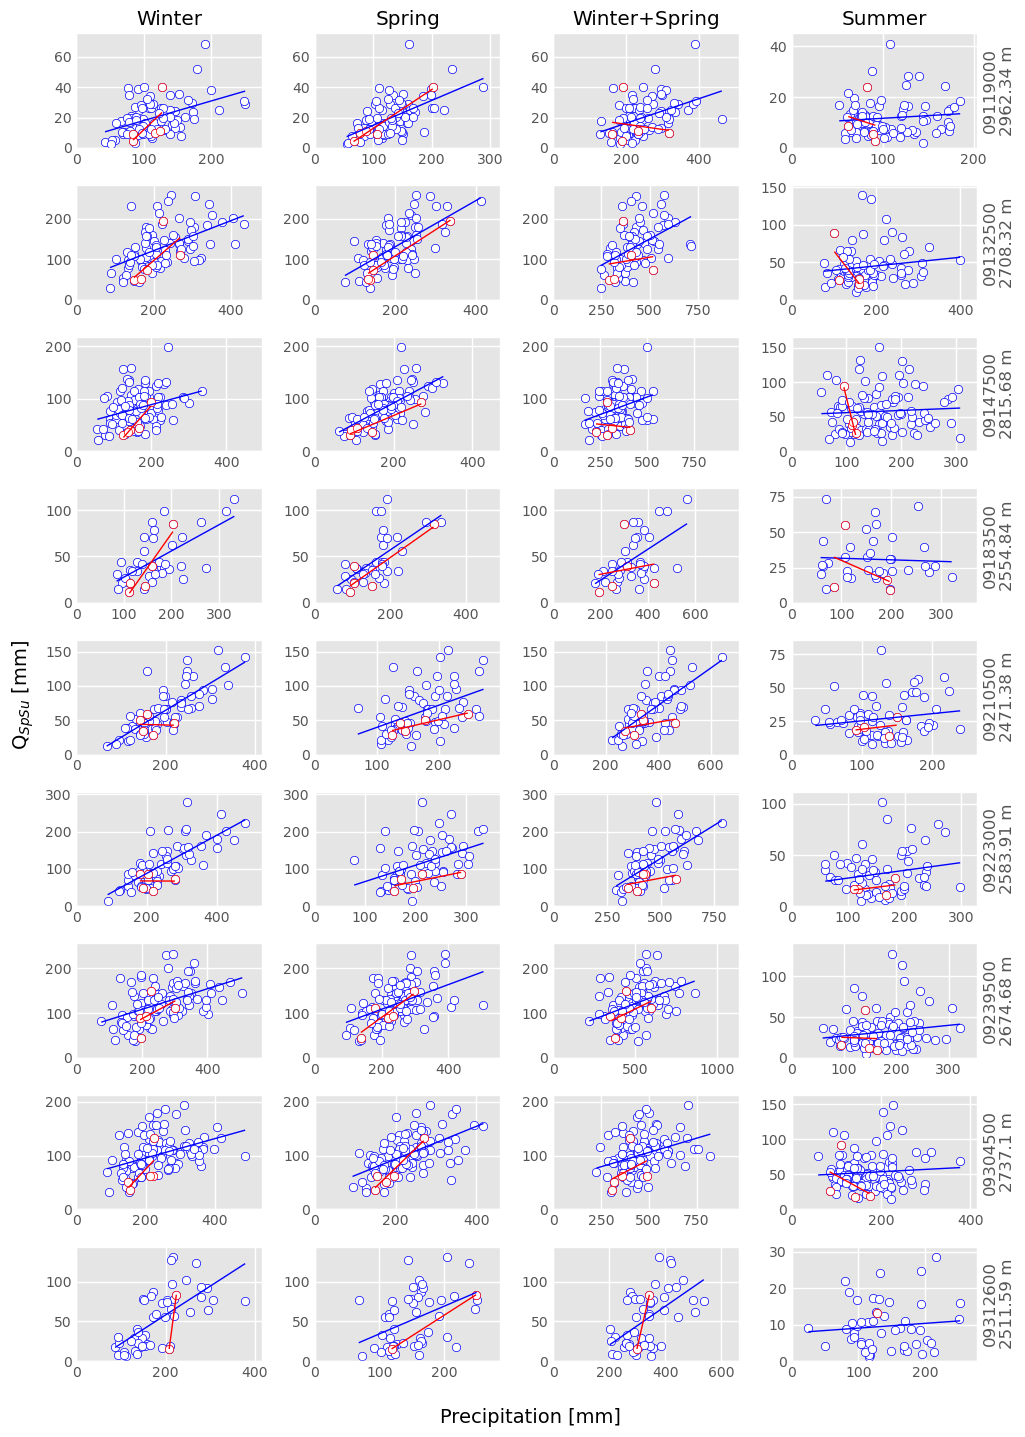

In [74]:
plt.style.use("ggplot")
fig, axs = plt.subplots(len(low_elevation_sites),4, figsize=(10,14), tight_layout=True)
for i,site_no in enumerate(low_elevation_sites):
    mean_elev = round(float(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no).elevation.max().values),2)
    ax = axs[i,0]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['winter_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'winter_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')

    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['winter_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,1]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['spring_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'spring_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['spring_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,2]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['wisp_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'wisp_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['wisp_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,3]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['summer_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day_summer']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'summer_ppt',
                var2 = 'q_mm_day_summer',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['summer_ppt'].max()*1.1)
    ax.set_ylim(0,(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day_summer']*30.425*3).max()*1.1)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"{site_no}\n{mean_elev} m")
axs[0,0].set_title('Winter')
axs[0,1].set_title('Spring')
axs[0,2].set_title('Winter+Spring')
axs[0,3].set_title('Summer')

fig.text(0.5, -0.02, 'Precipitation [mm]', ha='center', size=14)
fig.text(-0.02, 0.5, 'Q$_{SpSu}$ [mm]', va='center', rotation='vertical', size=14)

### <a id='toc7_1_2_'></a>[Mid Elevation Sites](#toc0_)

Text(-0.02, 0.5, 'Q$_{SpSu}$ [mm]')

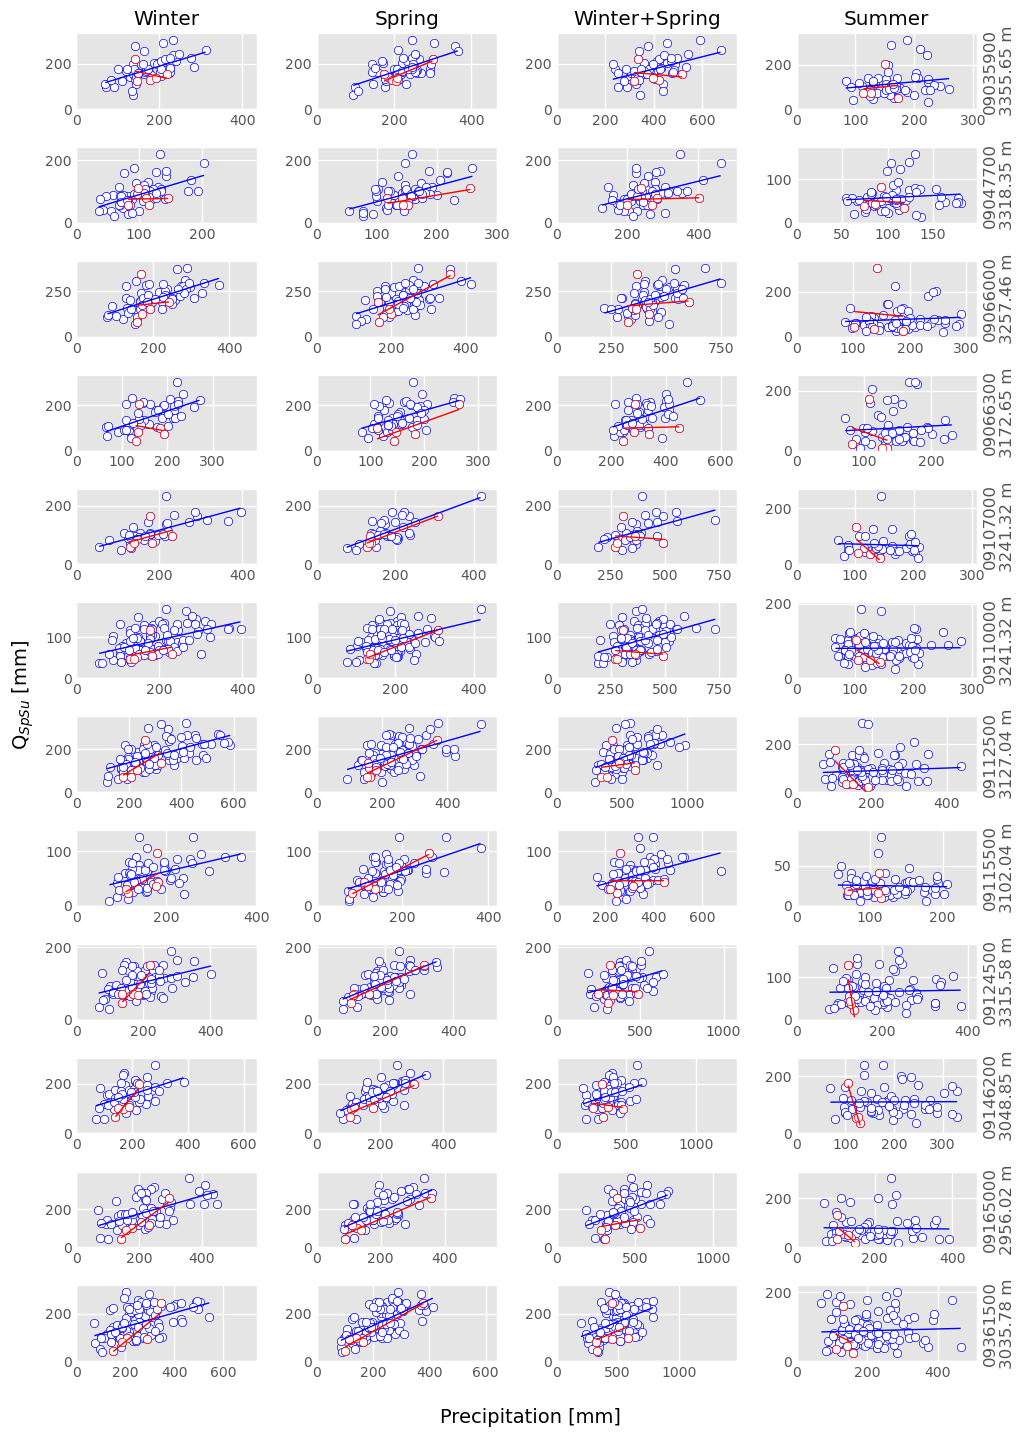

In [75]:
plt.style.use("ggplot")
fig, axs = plt.subplots(len(mid_elevation_sites),4, figsize=(10,14), tight_layout=True)
for i,site_no in enumerate(mid_elevation_sites):
    mean_elev = round(float(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no).elevation.max().values),2)
    ax = axs[i,0]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['winter_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'winter_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['winter_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,1]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['spring_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'spring_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['spring_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,2]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['wisp_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'wisp_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['wisp_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,3]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['summer_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day_summer']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'summer_ppt',
                var2 = 'q_mm_day_summer',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['summer_ppt'].max()*1.1)
    ax.set_ylim(0,(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day_summer']*30.425*3).max()*1.1)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"{site_no}\n{mean_elev} m")
axs[0,0].set_title('Winter')
axs[0,1].set_title('Spring')
axs[0,2].set_title('Winter+Spring')
axs[0,3].set_title('Summer')

fig.text(0.5, -0.02, 'Precipitation [mm]', ha='center', size=14)
fig.text(-0.02, 0.5, 'Q$_{SpSu}$ [mm]', va='center', rotation='vertical', size=14)

### <a id='toc7_1_3_'></a>[High Elevation Sites](#toc0_)

Text(-0.02, 0.5, 'Q$_{SpSu}$ [mm]')

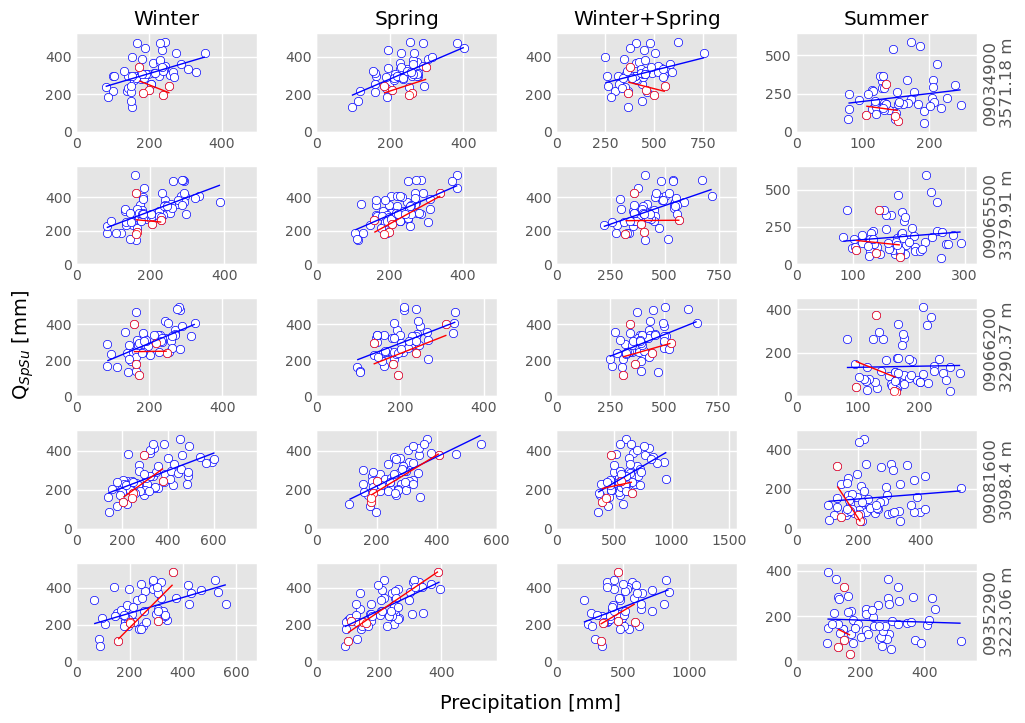

In [76]:
plt.style.use("ggplot")
fig, axs = plt.subplots(len(high_elevation_sites),4, figsize=(10,7), tight_layout=True)
for i,site_no in enumerate(high_elevation_sites):
    mean_elev = round(float(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no).elevation.max().values),2)
    ax = axs[i,0]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['winter_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'winter_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['winter_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,1]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['spring_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'spring_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')

    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['spring_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,2]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['wisp_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'wisp_ppt',
                var2 = 'q_mm_day',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['wisp_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,3]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['summer_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day_summer']*30.425*3,
            color='white',
            ec='blue')
    plotBestFit(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no), 
                var1 = 'summer_ppt',
                var2 = 'q_mm_day_summer',
                ax=ax,
                color='blue')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['summer_ppt'].max()*1.1)
    ax.set_ylim(0,(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day_summer']*30.425*3).max()*1.1)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"{site_no}\n{mean_elev} m")
axs[0,0].set_title('Winter')
axs[0,1].set_title('Spring')
axs[0,2].set_title('Winter+Spring')
axs[0,3].set_title('Summer')

fig.text(0.5, -0.02, 'Precipitation [mm]', ha='center', size=14)
fig.text(-0.02, 0.5, 'Q$_{SpSu}$ [mm]', va='center', rotation='vertical', size=14)

### <a id='toc7_1_4_'></a>[Run an ANOVA test looking at changes between elevation groups](#toc0_)

In [77]:
# Pull in HCDN precip data
winter_hcdn_p = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month==12, drop=True).groupby('year').mean()
spring_hcdn_p = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month==3, drop=True).groupby('year').mean()
summer_hcdn_p = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month==6, drop=True).groupby('year').mean()
fall_hcdn_p = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month==9, drop=True).groupby('year').mean()

In [78]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
dates = [date2DOWY(x) for x in hcdn_streamflow_daily_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_streamflow_daily_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_streamflow_dowy_ds = hcdn_streamflow_daily_ds.copy()
hcdn_streamflow_dowy_ds = hcdn_streamflow_dowy_ds.merge(dowy_da)

In [79]:
hcdn_streamflow_dowy_pre2000_ds = hcdn_streamflow_daily_ds.where(hcdn_streamflow_dowy_ds.WY<2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_streamflow_dowy_pre2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_streamflow_dowy_pre2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_streamflow_dowy_pre2000_ds = hcdn_streamflow_dowy_pre2000_ds.merge(dowy_da)

In [80]:
hcdn_streamflow_dowy_post2000_ds = hcdn_streamflow_daily_ds.where(hcdn_streamflow_dowy_ds.WY>=2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_streamflow_dowy_post2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_streamflow_dowy_post2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_streamflow_dowy_post2000_ds = hcdn_streamflow_dowy_post2000_ds.merge(dowy_da)

In [81]:
hcdn_streamflow_dowy_mean = hcdn_streamflow_dowy_ds.groupby('dowy').mean()
hcdn_streamflow_dowy_pre2000_mean = hcdn_streamflow_dowy_pre2000_ds.groupby('dowy').mean()
hcdn_streamflow_dowy_post2000_mean = hcdn_streamflow_dowy_post2000_ds.groupby('dowy').mean()

456.9238882729414
5.196752661064765e-145


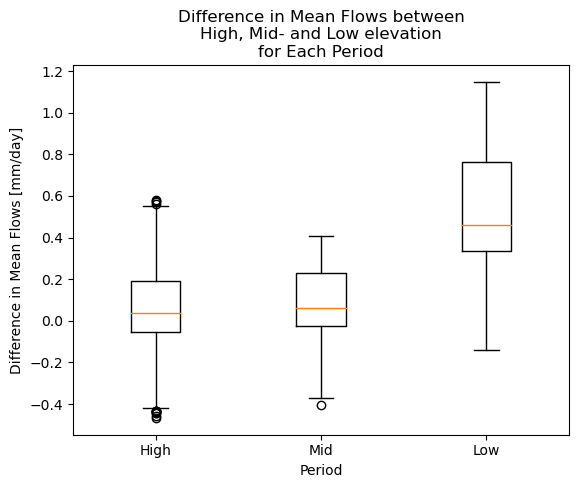

In [144]:
site_diff_1 = (np.log(hcdn_streamflow_dowy_pre2000_mean['q_mm_day'].sel(site_no='09065500')) - np.log(hcdn_streamflow_dowy_post2000_mean['q_mm_day'].sel(site_no='09065500') ))
site_diff_2 = (np.log(hcdn_streamflow_dowy_pre2000_mean['q_mm_day'].sel(site_no='09112500')) - np.log(hcdn_streamflow_dowy_post2000_mean['q_mm_day'].sel(site_no='09112500') ))
site_diff_3 = (np.log(hcdn_streamflow_dowy_pre2000_mean['q_mm_day'].sel(site_no='09312600')) - np.log(hcdn_streamflow_dowy_post2000_mean['q_mm_day'].sel(site_no='09312600') ))
# stats f_oneway functions takes the groups as input and returns an F and P-value
fvalue, pvalue = stats.f_oneway((site_diff_1), 
                                (site_diff_2),
                                (site_diff_3))
print(fvalue)
print(pvalue)
# Using boxplot, we can start to visually see differences between the periods
plt.boxplot([site_diff_1,
             site_diff_2,
             site_diff_3],
           labels=['High', 'Mid', 'Low'])

# Add labels
plt.xlabel('Basin')
plt.ylabel('Difference in Mean Flows [mm/day]')
plt.title('Difference in Mean Flows between\nHigh, Mid- and Low elevation\nfor Each Period');

In [130]:
# performing this to show the other way the ANOVA test can be done with another package
# reshape the d dataframe suitable for statsmodels package 
df_reshaped = pd.concat([site_diff_1.to_dataframe()[['site_no','q_mm_day']], 
                         site_diff_2.to_dataframe()[['site_no','q_mm_day']],
                         site_diff_3.to_dataframe()[['site_no','q_mm_day']], 
                         ]).reset_index()

# # Ordinary Least Squares (OLS) model - creates a linear fitted model between diff and site_nos
# # this function takes an R style function where one column is fitted (~) to another columns values
model = ols('q_mm_day ~ C(site_no)', data=df_reshaped).fit() 
# print model summary results
print(model.summary())
# significance of typ=2: This type tests for the sum of squares of one event after the other event. 
# This is applicable in this case we are comparing events after another event occurred
# from: https://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html
anova_table = sm.stats.anova_lm(model, typ=2)
# display the results table
anova_table

                            OLS Regression Results                            
Dep. Variable:               q_mm_day   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     456.9
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          5.20e-145
Time:                        13:20:34   Log-Likelihood:                 58.106
No. Observations:                1098   AIC:                            -110.2
Df Residuals:                    1095   BIC:                            -95.21
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

,sum_sq,df,F,PR(>F)
C(site_no),48.263865,2.0,456.923888,5.196753e-145
Residual,57.831220,1095.0,NaN,NaN


In [132]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform multiple pairwise comparison (Tukey HSD), 
# endog is response variable, groups are the tested groups to compare
period_comp = pairwise_tukeyhsd(endog=df_reshaped['q_mm_day'], groups=df_reshaped['site_no'], alpha=0.05)

# display the results table
print(period_comp)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower  upper  reject
------------------------------------------------------
09065500 09112500   0.0169 0.5804 -0.023 0.0568  False
09065500 09312600    0.453    0.0 0.4131 0.4928   True
09112500 09312600   0.4361    0.0 0.3962 0.4759   True
------------------------------------------------------


### <a id='toc7_1_5_'></a>[Quick Statistical test for a single site](#toc0_)

In [194]:
site = '09146200'
hcdn_annual_mean = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc')
single_site_pre = hcdn_annual_mean.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[:1999]
single_site_post = hcdn_annual_mean.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]

In [195]:
conf = 0.05
z_alpha = stats.norm.ppf(conf)
print("z_alpha = {}".format(z_alpha)) 

z_alpha = -1.6448536269514729


In [196]:
s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                   (single_site_post.std(ddof=1)**2)/len(single_site_post))
print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

Pooled standard deviation is 24.812191242855683 mm


In [197]:
# null hypothesis: no change in sample means
delta = 0*single_site_pre.mean()
# compute test statistic
z_test = ((single_site_post.mean()-single_site_pre.mean())-
          delta)/s_pooled
print("z-score = {}".format(np.round(z_test,2))) 

z-score = -1.5


p = 0.934


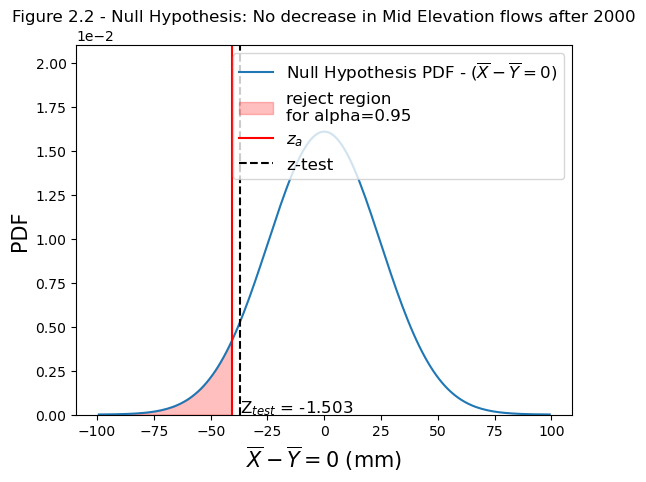

In [198]:
fig, ax = plt.subplots()

# Reference 1 - code adapted from Lab 2-1
# create null pdf
z = np.linspace(-4,4, num=160)*s_pooled
ax.plot(z, 
        stats.norm.pdf(z,delta,s_pooled), 
        label='Null Hypothesis PDF - ($\overline{X}-\overline{Y}=0$)') # 0 and 1 are mu and sigma

# # define alpha
alpha = 0.95
# # Plot the region that z_test would have to fall in in order for us to reject the null hypothesis
conf = 1-alpha
z_alpha = stats.norm.ppf(conf)
shade_region = np.linspace(np.min(z),z_alpha*s_pooled,10)
ax.fill_between(shade_region,
                stats.norm.pdf(shade_region,delta,s_pooled), 
                color='r', 
                alpha=0.25, 
                label='reject region\nfor alpha={}'.format(np.round(1-conf,2)))
# # Plot a line at 95% confidence interval
ax.axvline(z_alpha*s_pooled, 
            color='r', 
            label='$z_{a}$')

# # Plot a line at z_test
ax.axvline(z_test*s_pooled, 
            color='black', 
            linestyle='--', 
            label='z-test')
ax.text(z_test*s_pooled, 
         1.2e-4, 
         r'Z$_{test}$ = '+str(round(z_test,3)), 
         fontsize=12, 
         color='k')
# Add labels
ax.set_ylim((0,2.1e-2))
ax.set_xlabel('$\overline{X}-\overline{Y}=0$ (mm)', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.legend(fontsize=12)
ax.set_title('Figure 2.2 - Null Hypothesis: No decrease in Mid Elevation flows after 2000')
# compute p value
pvalue = 1 - stats.norm.cdf(z_test)
print("p = {}".format(np.round(pvalue,3)))

In [221]:
def closest_value_groupby(df, column_name, target_value):
    # Calculate the absolute differences between each value in the column and the target value
    differences = np.abs(df[column_name] - target_value)
    
    # Find the index of the closest value
    closest_index = differences.idxmin()
    
    # Get the closest value
    closest_value = df.loc[closest_index, column_name]
    
    return closest_index.dayofyear


### <a id='toc7_1_6_'></a>[Double Mass Plots](#toc0_)

In [132]:
# Plot all points and trend-line
def plotBestFit2(df, var1, var2, ax, color):
    m,b,r = precipFlowLinReg(df[var1],
                            df[var2])
    x = [df[var1].min(),
        df[var1].max()]
    y = [df[var1].min()*m+b,
        df[var1].max()*m+b]
    ax.plot(x,y, color=color, lw=1)

def doubleMassPlot(ds1, ax, to_plot=True):
    df1 = ds1['q_mm'].to_pandas()
    df2 = (ucrb_naturalized_streamflow['annual_flow_km3'] * 1e12 /(ucrb_basin_boundary.area.values[0]))
    combined_df = pd.concat([df1,df2], axis=1).replace(0, np.nan).dropna()
    residuals = combined_df[0] - combined_df['annual_flow_km3']
    combined_df_cumsum = combined_df.cumsum()
    if to_plot:
        ax.scatter(combined_df_cumsum[0].loc[:2000].values, combined_df_cumsum['annual_flow_km3'].loc[:2000].values,
                color='white',
                ec='red')
        if len(combined_df_cumsum) > 2:
            plotBestFit2(combined_df_cumsum.loc[:2000], 
                    var1 = 0,
                    var2 = 'annual_flow_km3',
                    ax=ax,
                    color='red')
        ax.scatter(combined_df_cumsum[0].loc[2000:2022].values, combined_df_cumsum['annual_flow_km3'].loc[2000:2022].values,
                color='white',
                ec='blue')
        if len(combined_df_cumsum.loc[2000:2022]) > 2:
            plotBestFit2(combined_df_cumsum.loc[2000:2022], 
                    var1 = 0,
                    var2 = 'annual_flow_km3',
                    ax=ax,
                    color='blue')
    return residuals

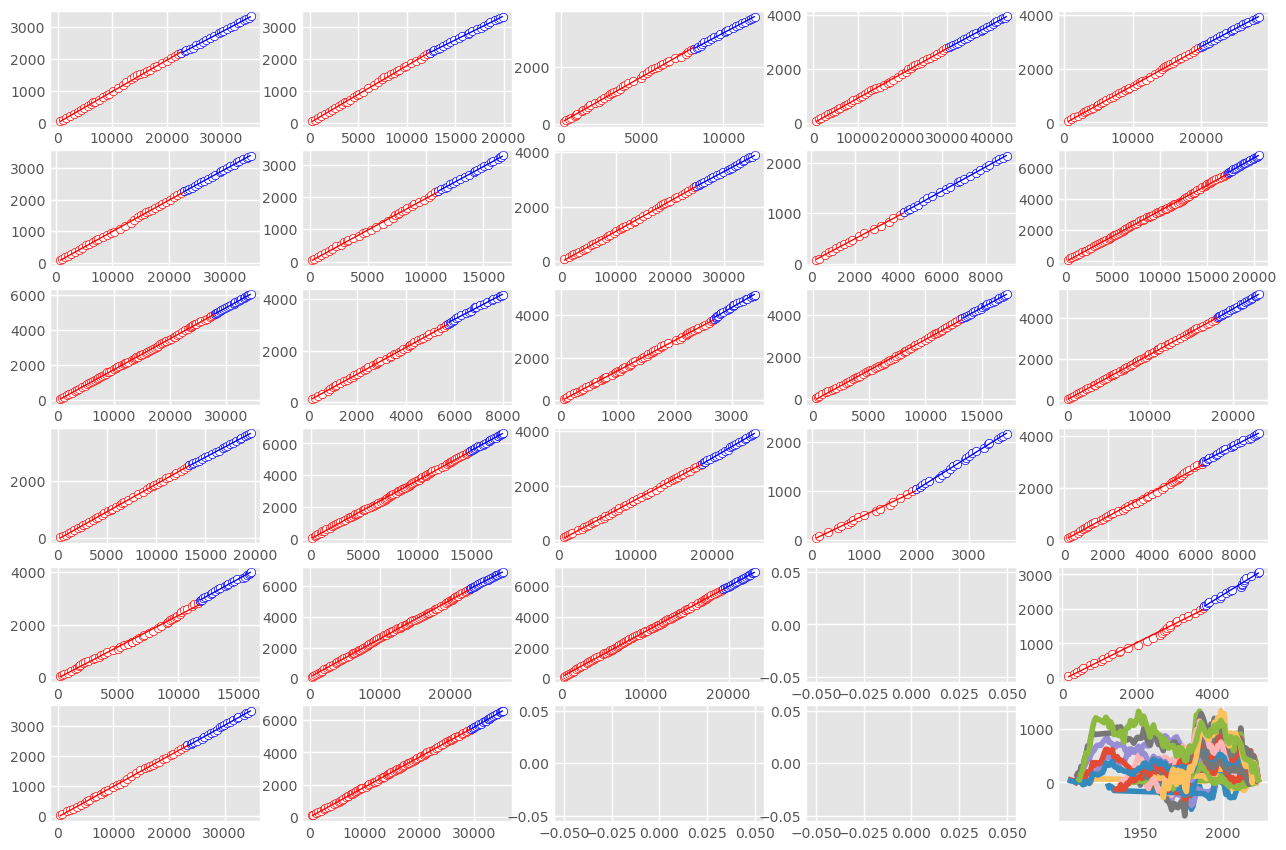

In [131]:
fig, axs = plt.subplots(6,5, figsize=(14,10))
axs = axs.ravel()
residuals = []
for i,site_no in enumerate(hcdn_q_spring_summer_mean_ds.site_no.values):
    residuals.append(doubleMassPlot(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no),ax=axs[i]))